# Periodicity Detection In The Wild

In the tutorial so far, you've learned a bit about different Fourier methods that help you find and characterize periodic signals. In this tutorial, we are going to look at some of the situations you may encounter in scientific research, and the various pitfalls that can make periodicity detection challenging. 

## Stingray

In this tutorial, we are going to make use of a Python package called [`stingray`](https://stingray.readthedocs.io/en/latest/). We are writing this package to help researchers do Fourier analysis on their light curves, and also are developing more spectral timing capabilities. As many open-source packages, it is a service to the community, from us as members of the community. We do our best to test the code, but bugs are inevitable. If you find a bug, please [report it](https://github.com/StingraySoftware/stingray/issues). If you found a bug and think you know how to fix it, you can either directly submit a [pull request](https://github.com/StingraySoftware/stingray/pulls), or you can contact us (see "How to get involved" in the [stingray docs](https://stingray.readthedocs.io/en/latest/)), and we'll guide you through the process. If you have an idea for a new feature, we'd love to hear from you, too! If you'd like to contribute, we'd _especially_ like to hear from you. Writing open-source software can be a lot of work, but it's also really fun and rewarding.

## Imports

With that said, let's import some libraries so we can actually generate some data (in this tutorial, we'll mostly work with simulated data), and then analyse it.

In [1]:
# plotting
%matplotlib notebook
import matplotlib.pyplot as plt

# optional seaborn imports, comment out if you don't have 
# or don't want to use seaborn
import seaborn as sns
sns.set_style('whitegrid')

# numerical Python libraries
import numpy as np
import scipy.stats

## Classical Significance Estimation

So you've made an observation of a particular source in the sky. You think it might be a pulsar, or a cataclysmic variable, or some other astronomical source with regular variations in brightness, so you'd like to find out whether you can detect a periodic signal. If you can,  that'd be a great hint toward the nature of the source you observed.

The patch of sky you observe is otherwise boring, there's no other source nearby, and your telescope is also well-behaved (I can dream, right?), so you think there should be no other source of variability in the data. What you expect is a *constant* light curve, with a possible periodic signal superimposed. 

Your observation was taken in X-rays, and was a filler observation that the telescope squeezed in between its regular programme, so you have about 100s of data.

In [2]:
# set up random seed for reproducibility
np.random.seed(20210104)

# set up the observation parameters
tobs = 100.0 # duration of the observation
tstart = 0.0 # start time of the observation
mean_cr = 100000.0 # mean count rate
nphot_expect = tobs * mean_cr # expected total number of photons

# set up the periodic signal:
period = 1.0 # period of the signal
phase = np.random.uniform(0, 2*np.pi) # pick a phase at random
amp = 0.1 #amplitude of the signal

# now we can generate a binned light curve
nbins_fine = 1e4 # make many bins
time = np.linspace(tstart, tobs, nbins_fine)
counts_per_bin = mean_cr / nbins_fine
amp_per_bin = amp * mean_cr / nbins_fine

flux = counts_per_bin + amp_per_bin * np.sin(2 * np.pi * time/ period + phase)
counts = np.random.poisson(flux)

<IPython.core.display.Javascript object>


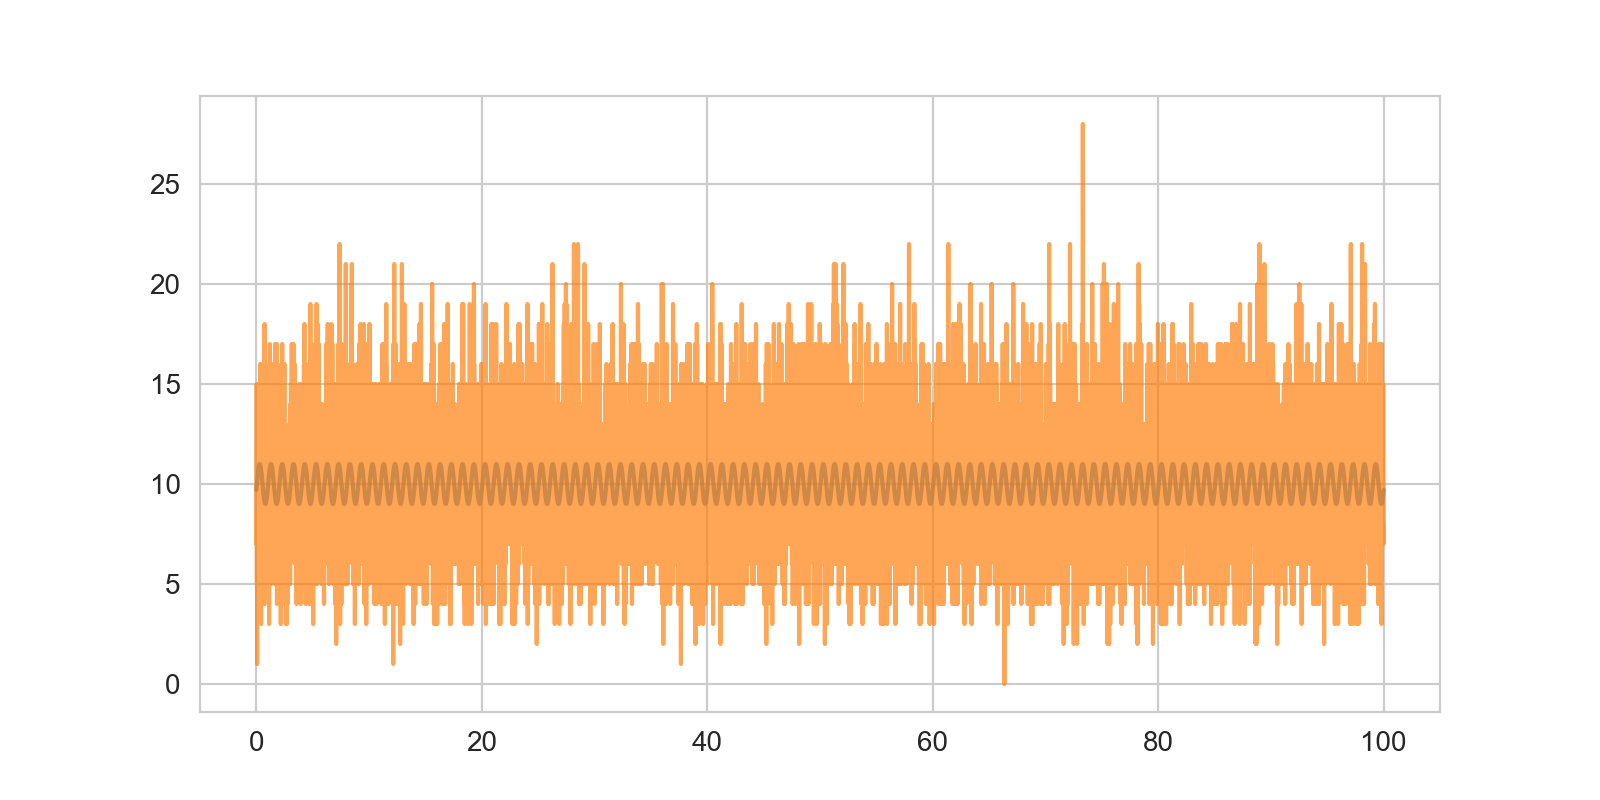

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time, flux, alpha=0.7)
ax.plot(time, counts, alpha=0.7)

Let's save this to file:

In [4]:
np.savetxt("period_detect_example.txt", np.array([time, counts]).T)

Let's first load a light curve to work with. I have saved an example data set for you in `period_detect_example.txt`, which you can load using `np.loadtxt`:

In [5]:
data = np.loadtxt("period_detect_example.txt")

In [6]:
time = data[:,0]
counts = data[:,1]

Now we can encode this as a `Lightcurve` object:

In [7]:
from stingray import Lightcurve

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/crossspectrum.py:21: UserWarning: Using standard scipy fft
  warnings.warn("Using standard scipy fft")


In [8]:
lc = Lightcurve(time, counts)

<IPython.core.display.Javascript object>


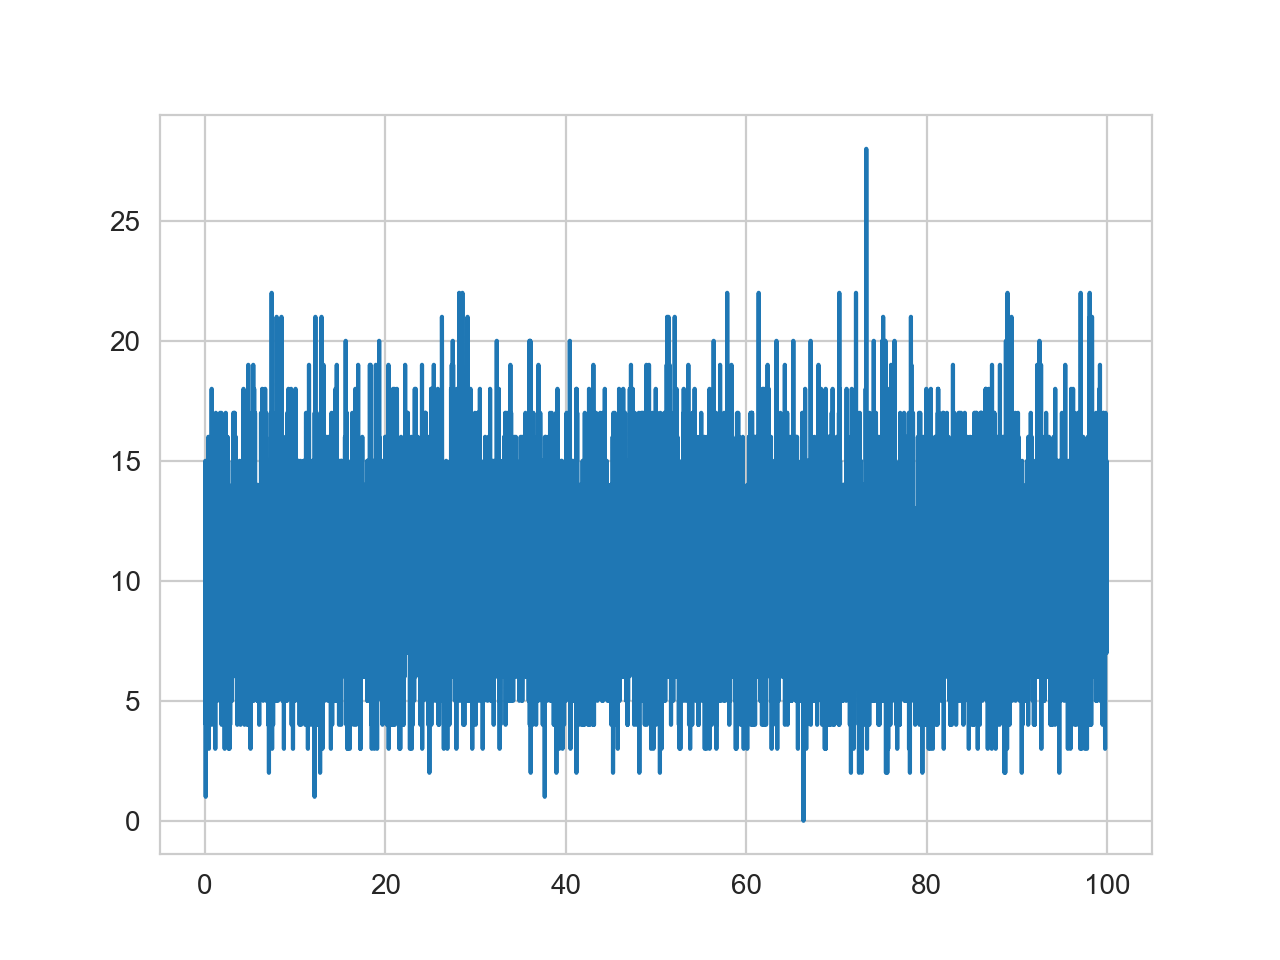

In [9]:
lc.plot()

`Lightcurve` has a range of useful attributes and methods to help the analysis, which you can explore in our [documentation](https://stingray.readthedocs.io/en/latest/core.html#working-with-lightcurves). You can do things like add two light curves together, truncate and join light curves.

So, that light curve above doesn't look like much! Is there a periodic signal in it? We don't know! Let's make a periodogram to find out:

In [10]:
from stingray import Powerspectrum

In [11]:
ps = Powerspectrum(lc, norm="leahy")

<IPython.core.display.Javascript object>


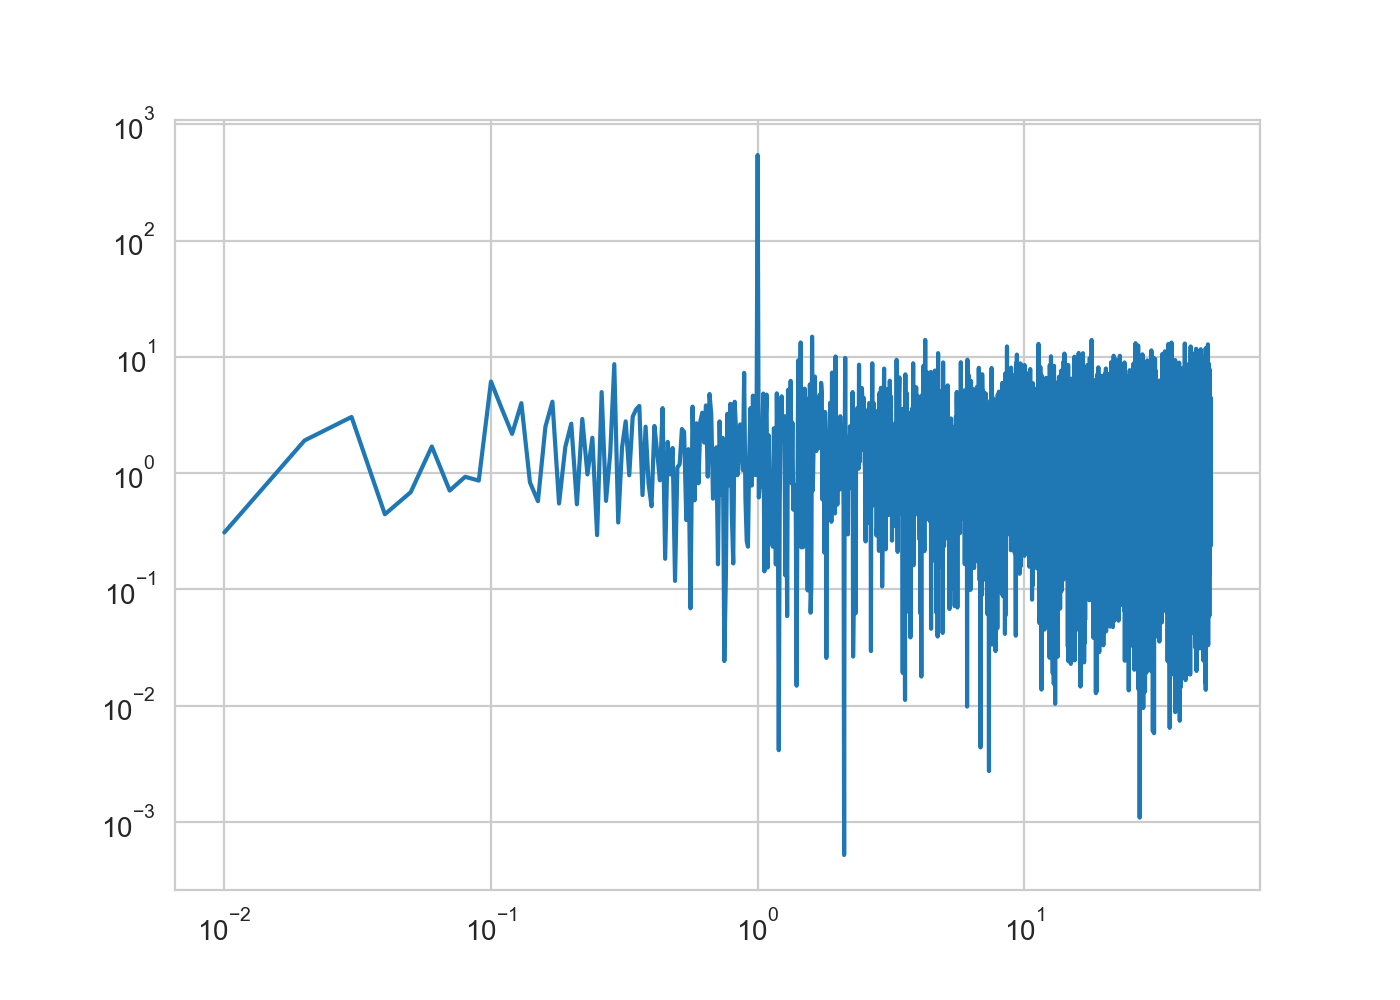

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.loglog(ps.freq, ps.power)

the `Powerspectrum` object also has a number of different useful properties. One particular one is that when creating PSDs, one can choose a different normalization. We have implemented three that are commonly used in X-ray astronomy. The **Leahy** normalization, the **fractional rms** normalization, and the **absolute rms** normalization. By default, the class will use the Leahy normalization, which has convenient properties for period detection. Let's compare the three:


In [13]:
ps_leahy = Powerspectrum(lc, norm="leahy")
ps_frac = Powerspectrum(lc, norm="frac")
ps_abs = Powerspectrum(lc, norm="abs")

<IPython.core.display.Javascript object>


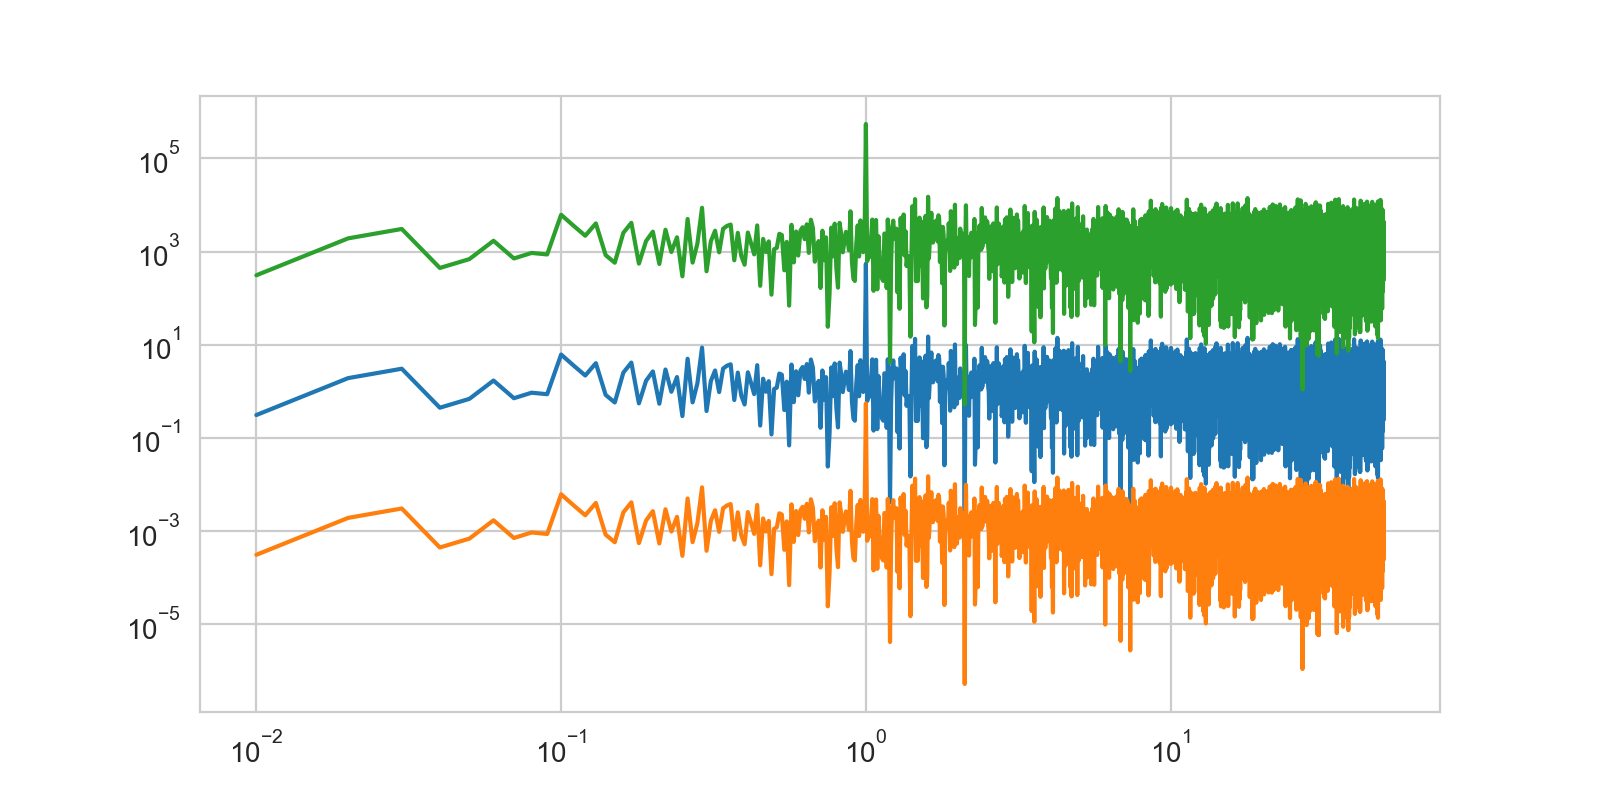

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(ps_leahy.freq, ps_leahy.power)
ax.loglog(ps_frac.freq, ps_frac.power)
ax.loglog(ps_abs.freq, ps_abs.power)

They're exactly the same, except for a normalization factor. The fractional and absolute rms normalizations are very useful when looking at stochastic noise processes that extend over a range of different frequencies: they are useful for calculating how much variance is contained in a particular feature in the periodogram.

But back to the period detection problem. From the plots above, there's a clear signal one can see with their eyes. That's great! But how do we formally decide about the significance? For this, it's helpful to know that periodograms of noise processes generally follow a particular statistical distribution: a $\chi^2$ distribution with two degrees of freedom. In Leahy normalization, if no signal is present, the distribution *always* has a mean of 2 and a variance of 4 (note that in other normalizations, this is not true!). 

Caveat: *always* is only true without the presence of instrumental effects like dead time, but that is a can of worms we mostly won't open today.

Let's take a look at the distribution of powers we've observed. The easiest way to see this is to compare the powers we derived with an actual $\chi^2$ distribution:

In [15]:
min_power = 0
max_power = 50

In [16]:
chi2 = scipy.stats.chi2(2.0)
x = np.linspace(min_power, max_power, 1000)
pdf = chi2.pdf(x)

<IPython.core.display.Javascript object>


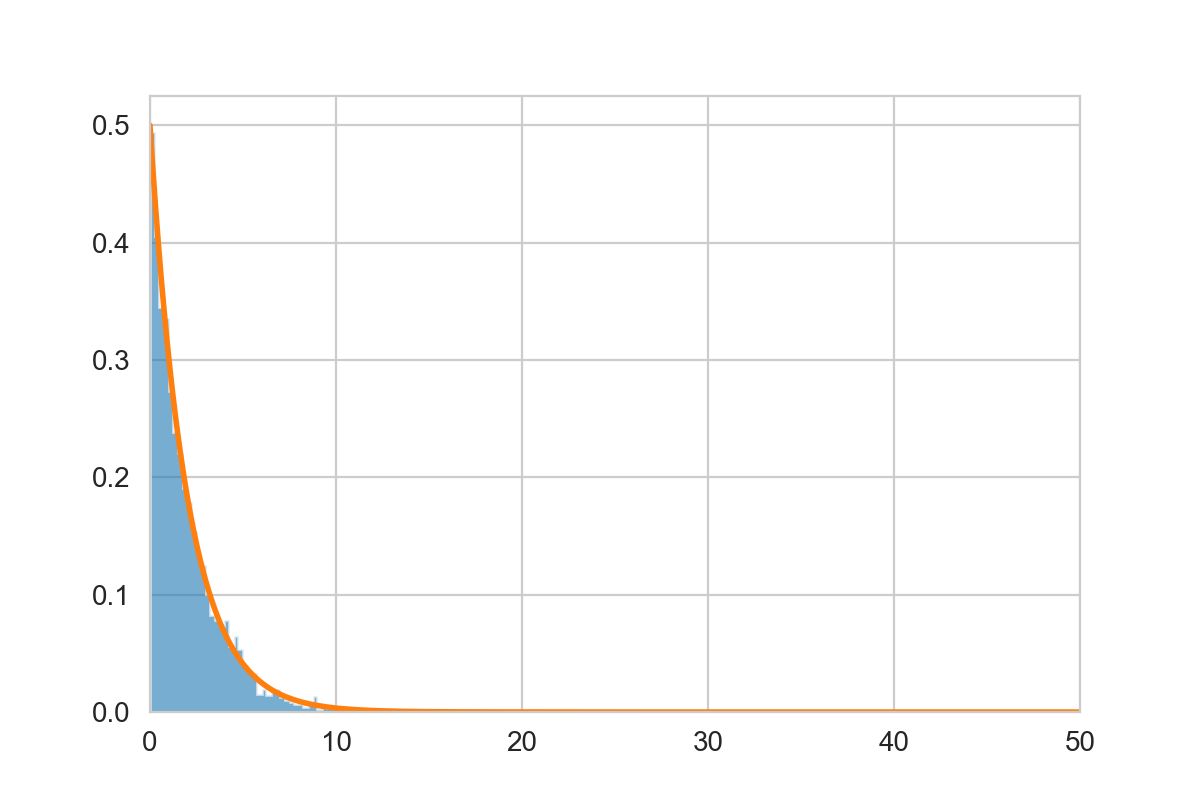

(0, 50)

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(ps.power, bins=200, histtype="stepfilled", 
        alpha=0.6, density=True, range=[min_power,max_power])
ax.plot(x, pdf, lw=2)
ax.set_xlim(min_power, max_power)

Okay, so that looks pretty good. What we now want to calculate is the *probability* of seeing the a power as high as the peak in the periodogram, given only noise. For that, we compute the *tail probability* above the observed maximum power, so the integral under the PDF above the maximum observed power. As you can see from the histogram above, the $\chi^2$ probability drops off really sharply and is close to zero above a power of about 10, so we can expect that tail probability to be really small.

We could calculate this by hand (hint: there are methods implemented in `scipy.stats` that help with that), but stingray actually has that implemented:

In [18]:
from stingray.stats import pds_probability

In [19]:
pds_probability(np.max(ps.power))

3.200164872419352292e-119

This probability is, as you can see, really small. The function above has some helpful other keywords. For example, you can set the *number of trials*. If you search over a range of different frequencies, you have to take into account that you might see outliers just by chance. You can correct the probability above by the number of frequencies we've searched, so the number of frequencies in the periodogram:

In [20]:
ntrial = len(ps.power)

In [21]:
pds_probability(np.max(ps.power), ntrial=ntrial)

1.5997624197224141308e-115

That probability is not quite as significant, but still significant beyond a doubt. 

**Important**: Keep in mind, however, that a p-value is never evidence *for* the hypothesis you're trying to test, it is always evidence *against* the null hypothesis (here: "There is no periodic signal in the data"). P-values can be small for other reasons than the signal you're trying to detect, as we'll see in a little while.

**Important**: There are a range of different standard normalizations for periodograms. The function above *only* works for the Leahy normalization, where the periodogram is normalized such that white noise will follow an exact $\chi^2$ distribution with two degrees of freedom, centred on a mean of 2 and with a variance of 4. Periodograms in different normalizations (e.g. the fractional rms normalization) need to be renormalized to Leahy in order for the above method to work!

If you're interested in finding *all* of the frequencies in the periodogram that are above a certain significance threshold, you can use the method implemented for the Powerspectrum class:

In [22]:
ps.classical_significances(threshold=0.001, trial_correction=True)

array([[1.59976242e-115],
       [9.90000000e+001]], dtype=float128)

This leaves us with one detection, and returns both the significance, as well as the frequency where that potential periodic signal was detected.

You can also calculate a given threshold above which you'd consider a candidate power significant, which can be helpful for visualization:

In [23]:
from stingray.stats import pds_detection_level

In [24]:
detec_level = pds_detection_level(epsilon=0.01, ntrial=ntrial)

Here, we're assuming that are looking for signals that only have a 1:100 chance of occurring by chance in a periodogram without signal, corrected for the number of trials. Let's plot that:

<IPython.core.display.Javascript object>


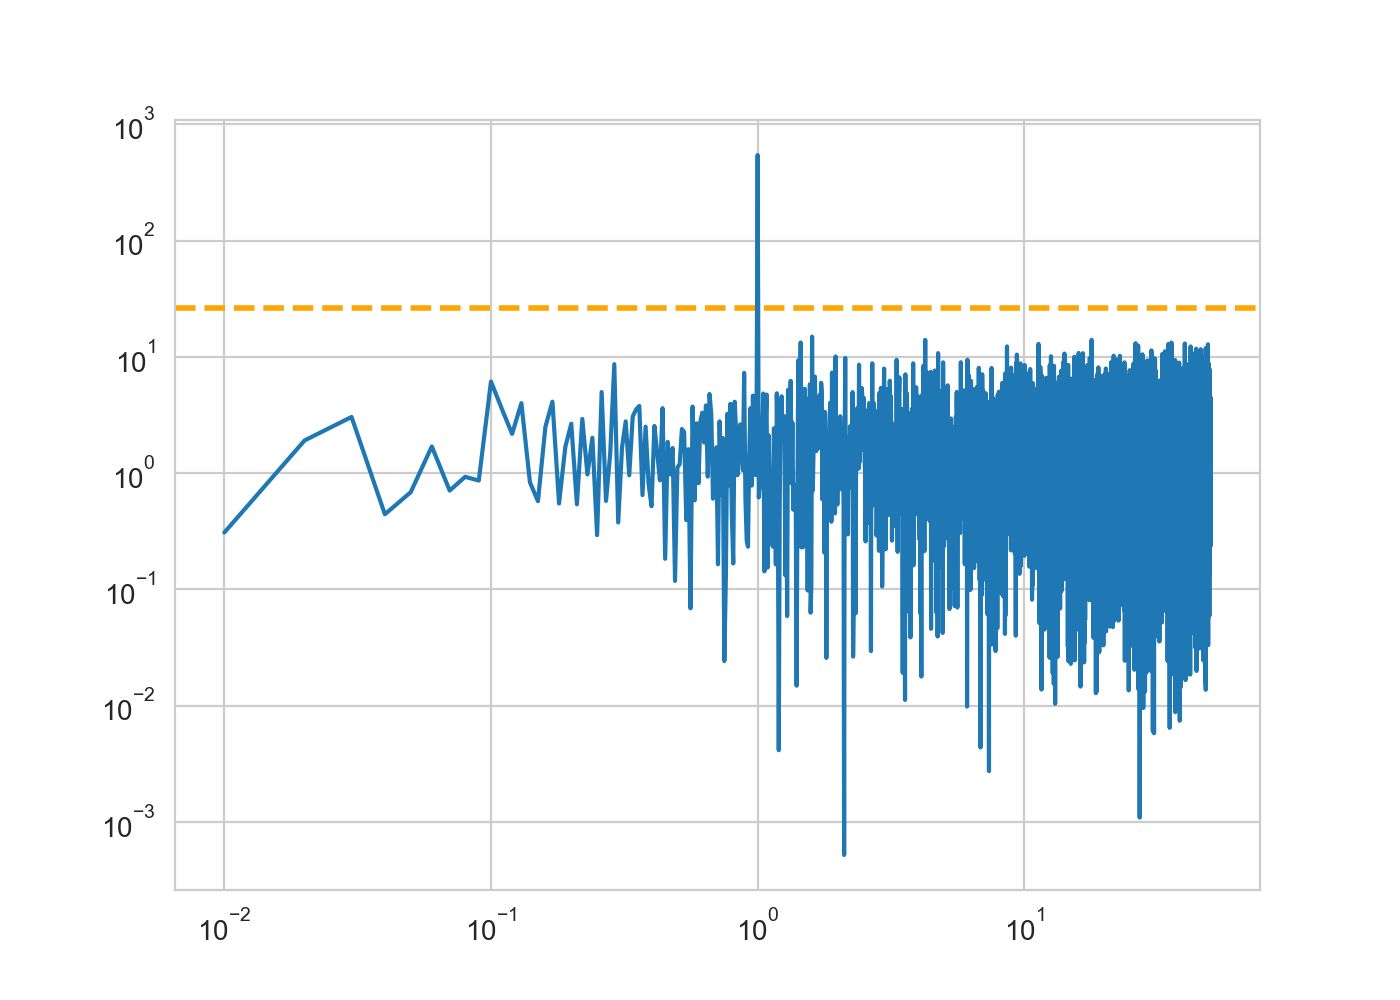

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.loglog(ps.freq, ps.power)
ax.axhline(detec_level, lw=2, color="orange", ls="dashed")

**Exercise**: What level of significance would you consider acceptable? Why? Discuss.

**Exercise**: Below is a function to generate the same kind of light curve as is saved in the file. Play around with the amplitude above. How low can you make the amplitude before the signal would no longer be significant. (You can also play around with different properties if you want to!)

In [26]:

def generate_lightcurve(amplitude=0.1, period=1.0, 
                        tobs=100.0, mean_cr=1e5):
    """
    Generate a light curve with a periodic signal and 
    Poisson counting statistics. 
    
    Parameters
    ----------
    amplitude : float, default 0.1
        The amplitude of the periodic signal in the data, 
        parametrized as a fraction of the mean count rate.
        
    period : float, default 1.0
        The period of the sinusoidal signal we are injecting 
        into the data.
        
    tobs : float, default 100.0
        The total length of the observed light curve
        
    mean_cr : float, default 1e5
        The constant mean count rate, in counts per second.
        
    Returns
    -------
    time : numpy.ndarray
        An array of time stamps, denoting the middle of each 
        time bin
        
    counts : numpy.ndarray
        An array of measured photon counts in each time bin.
    

    """
    # set up the observation parameters
    tstart = 0.0 # start time of the observation
    nphot_expect = tobs * mean_cr # expected total number of photons

    # set up the periodic signal:
    phase = np.random.uniform(0, 2*np.pi) # pick a phase at random

    # now we can generate a binned light curve
    nbins_fine = 1e4 # make many bins
    time = np.linspace(tstart, tobs, nbins_fine)
    counts_per_bin = mean_cr / nbins_fine
    amp_per_bin = amp * mean_cr / nbins_fine

    flux = counts_per_bin + amp_per_bin * np.sin(2 * np.pi * time/ period + phase)
    counts = np.random.poisson(flux)
    
    return time, counts

**Exercise**: Can you think of situations where the above hypothesis test would not be appropriate? How could this be broken in real data? Share in the chat.

**Exercise**: The (Q)PO Detection Game

### Pulsar Methods

The above works well for signals that are approximately sinusoidal. However, in practice, many sources are periodic, but the shape of the light curve within each period deviates significantly from a sinusoidal signal. Some pulsars, for example, have multiple narrow peaks per period. In the periodogram, this translates into the power being spread into multiple harmonics: peaks at multiples of the fundamental frequency of the signal. While you can still detect these signals with a standard periodogram, you lose some detection power from spreading the signal into multiple bins. Pulsar astronomers therefore use related methods like epoch folding statistics and especially the $Z^2$ statistic, the latter of which has a better detection power for non-sinusoidal signals. You can read more about the $Z^2$ statistic in [Buccheri, 1983](https://ui.adsabs.harvard.edu/abs/1983A%26A...128..245B/abstract) and (warning, shameless self-promotion) in a soon-to-be-published paper by [Bachetti, under review](https://ui.adsabs.harvard.edu/abs/2020arXiv201211397B/abstract). A range of pulsar methods are implemented in `stingray`, with detailed instructions in [the documentation](https://stingray.readthedocs.io/en/latest/pulsar.html).


## Quasi-Periodic Oscillations

One way the above can be broken is when signals are not strictly periodic, but *quasi-periodic*. Oscillations can be quasi-periodic in multiple ways. For example, their period can vary as a function of time: often in practice, it jitters around some mean value. The amplitude can also vary as a function of time. Both lead to signals that can't be adequately described with a single frequency.

Let's take a look at an example:

In [27]:
from stingray.simulator.simulator import Simulator

In [28]:
def lorentzian(x, amp, x0, fwhm):
    fac1 = amp * (fwhm/2)**2.
    fac2 = (fwhm/2)**2. + (x - x0)**2.
    return fac1/fac2

In [29]:
qpo_amp = 1.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 20.0 # centroid frequency of the QPO, in Hz
qpo_qual = 10.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

rms_obs = 0.15 # fractional RMS amplitude of the QPO

tobs = 100.0 # total duration in seconds
dt = 0.01 # time step of the output light curve
npoints = int(np.round(tobs/dt)) # total number of points in original light curve

mean_countrate_obs = 500
mean_counts_obs = mean_countrate_obs * dt

df = 1.0/tobs # frequency resolution of the PSD/CSD
fmax = 0.5/dt # maximum frequency in the CSD/PSD


# list of frequencies
freq = np.linspace(df, fmax, num=npoints//2)

# generate theoretical spectrum
mspec_obs = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)



<IPython.core.display.Javascript object>


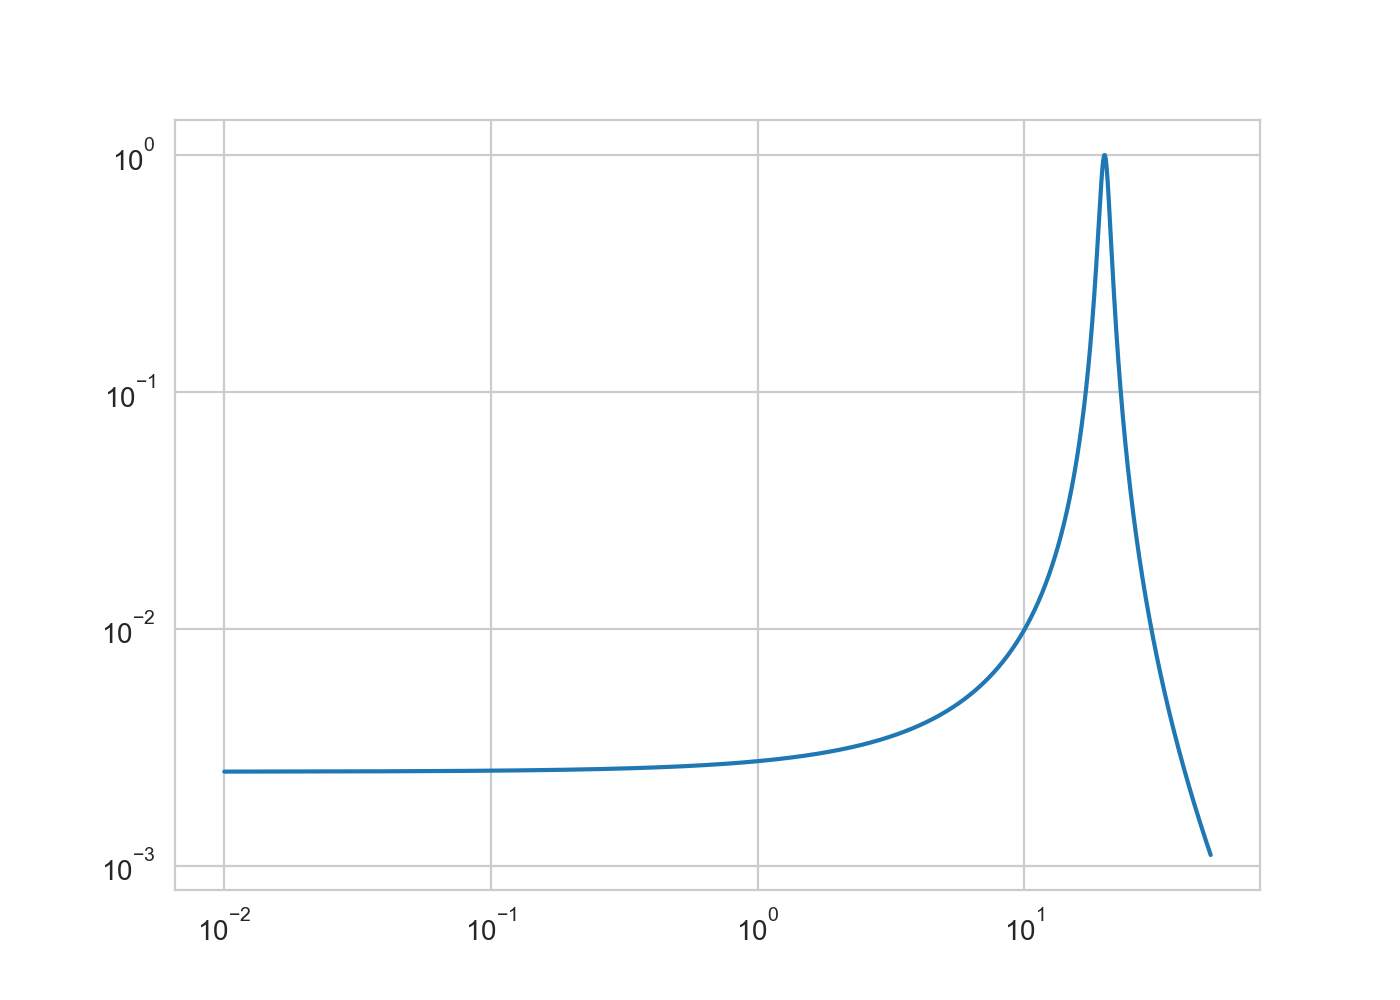

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.loglog(freq, mspec_obs)

In [31]:
sim = Simulator(dt=dt, N=2*len(mspec_obs), mean=mean_counts_obs, rms=rms_obs)

In [32]:
lc_sim = sim.simulate(mspec_obs)
lc_sim.counts = np.random.poisson(lc_sim.counts)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:118: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


We need to save this for later use:

In [33]:
np.savetxt("period_detect_example2.txt", np.array([lc_sim.time, lc_sim.counts]).T)

There's another fun light curve I've saved for you in the repository, under `period_detect_example2.txt`, which you can load in the same way:

In [34]:
data = np.loadtxt("period_detect_example2.txt")
time = data[:,0]
counts = data[:,1]
lc_sim = Lightcurve(time, counts)

<IPython.core.display.Javascript object>


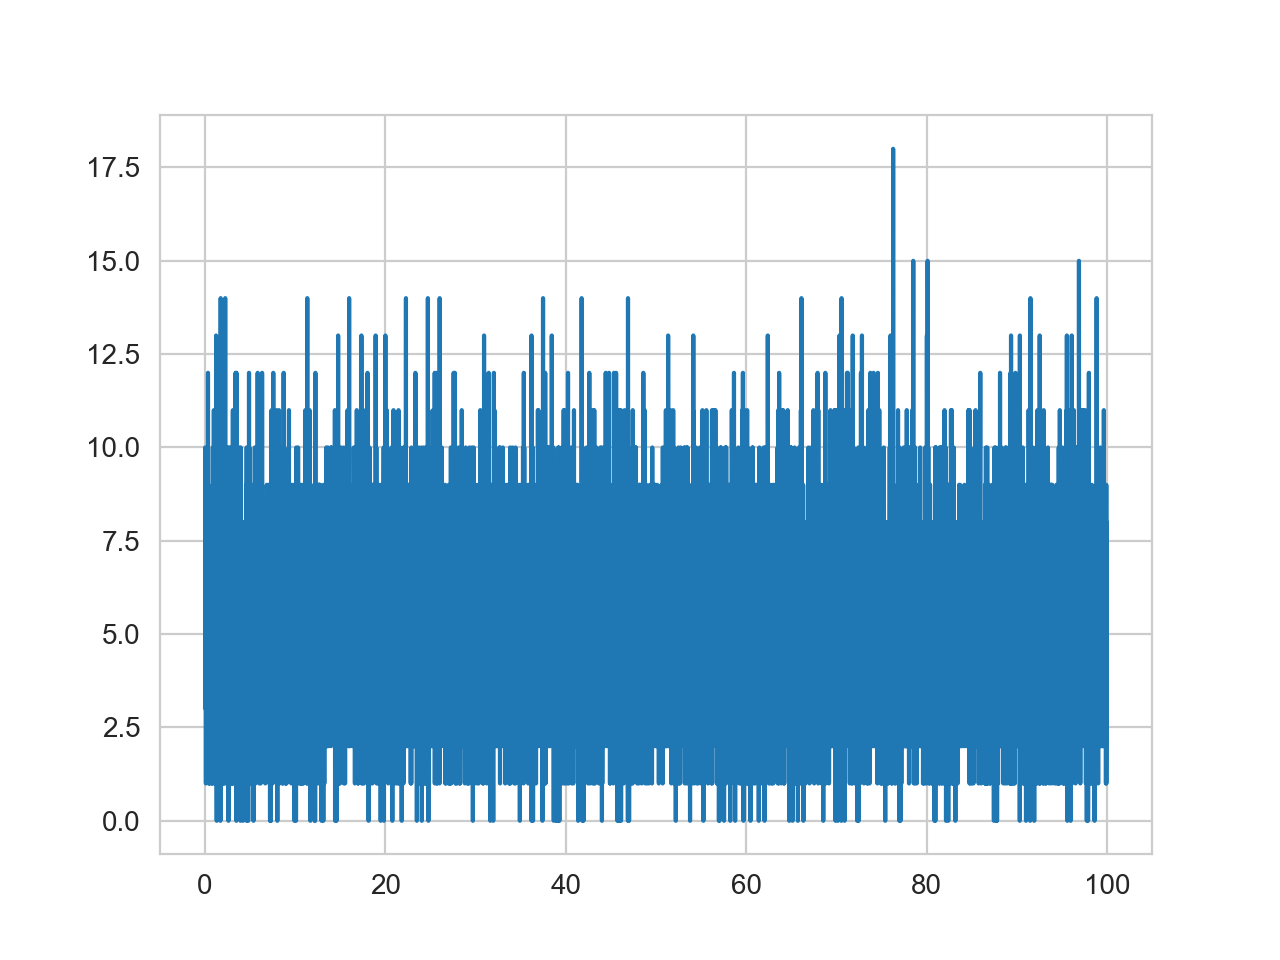

In [35]:
lc_sim.plot()

That also doesn't look super exciting. What does the periodogram look like?

In [36]:
ps_sim = Powerspectrum(lc_sim, norm="leahy")

<IPython.core.display.Javascript object>


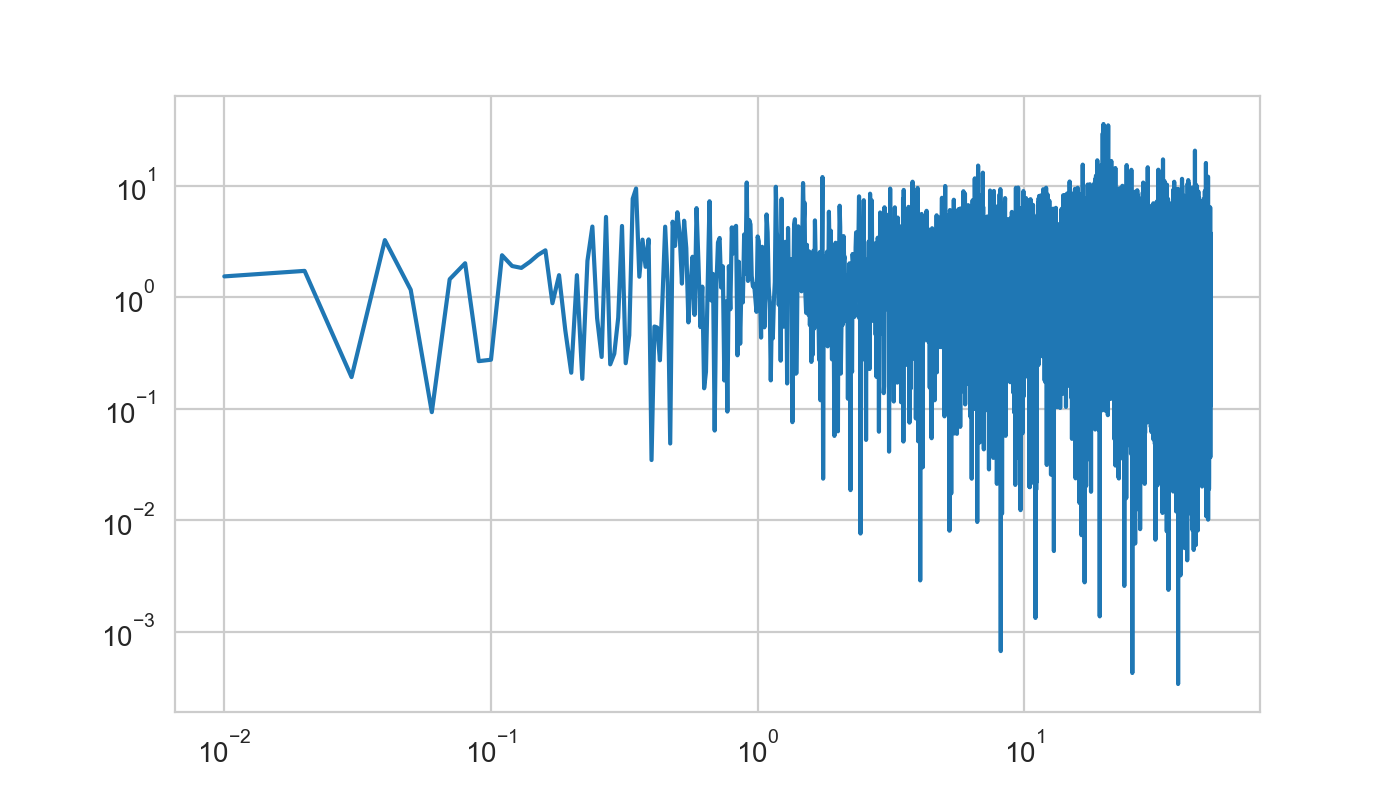

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.loglog(ps_sim.freq, ps_sim.power)

Well, you can sort of see a signal, but it's not very clear. 

It is a quirky property of periodograms that just collecting more data won't actually change the noise properties of the periodogram: if we observed twice as long a light curve, we'd be adding more *frequencies* to the periodogram, but they would still follow the same $\chi^2$ distribution with two degrees of freedom. But one thing we can do to bring down the noise is to *average* either frequencies or periodograms from multiple light curves. In practice, what one might often do (and what will be really important in spectral timing later), is chop the observed light curve up into multiple segments, and then average the periodograms of those segments together. 

Doing that with Stingray is easy:

In [38]:
from stingray import AveragedPowerspectrum

In [39]:
aps_sim = AveragedPowerspectrum(lc_sim, segment_size=1.0, norm="leahy")

100it [00:00, 502.67it/s]


What the above command does is chop our 100-second light curve into segments of 1 second each, for a total of 100 segments. Each segment is Fourier-transformed into a periodogram, and the resulting set of ten periodograms are averaged together. What does the result look like? Let's compare it to the original periodogram:

<IPython.core.display.Javascript object>


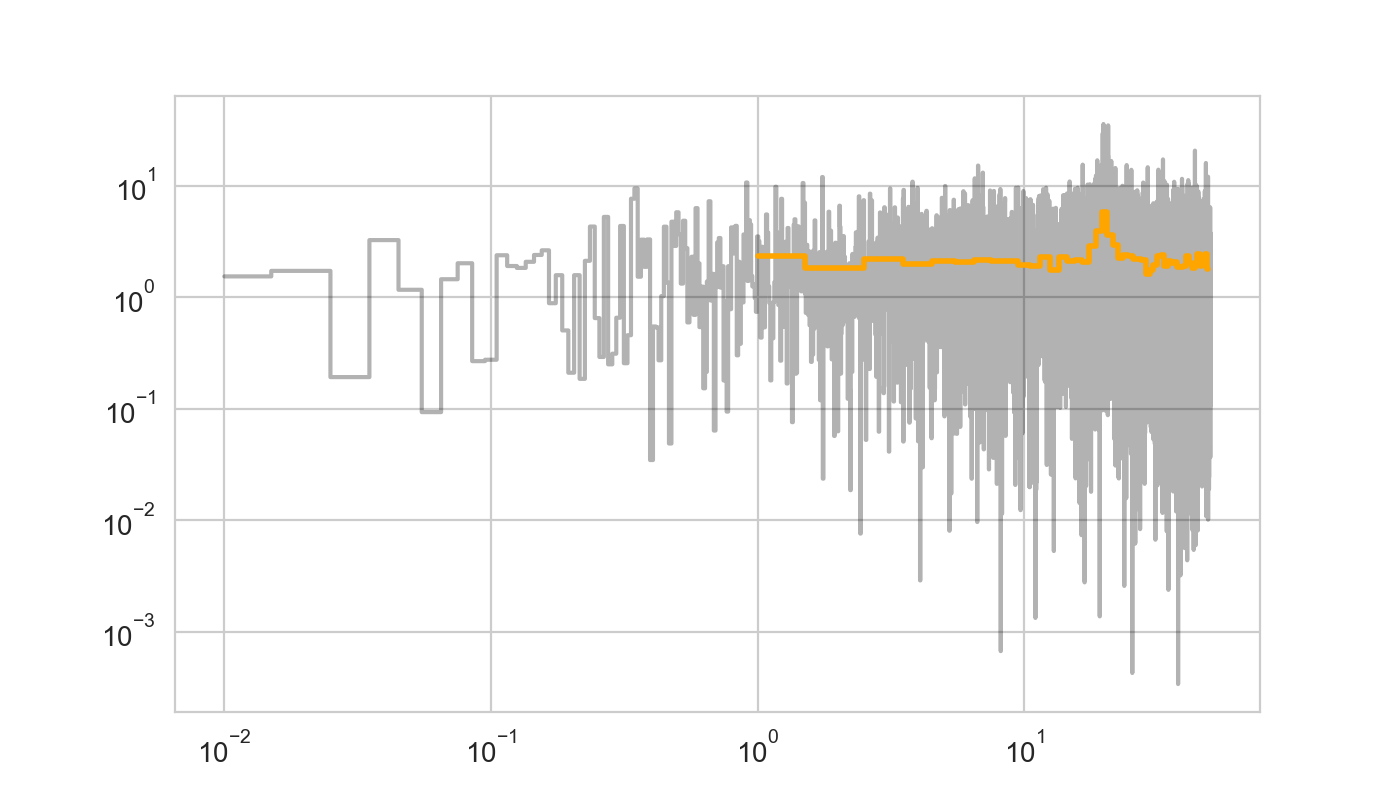

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", c="black", alpha=0.3)
ax.loglog(aps_sim.freq, aps_sim.power, ds="steps-mid", c="orange", lw=2)

Okay, that looks much better. One thing that you might be able to see is that the signal isn't  concentrated in a single bin, like the periodic signal was. What does that mean for our significance detection? Well, let's plot the same threshold from last time:

<IPython.core.display.Javascript object>


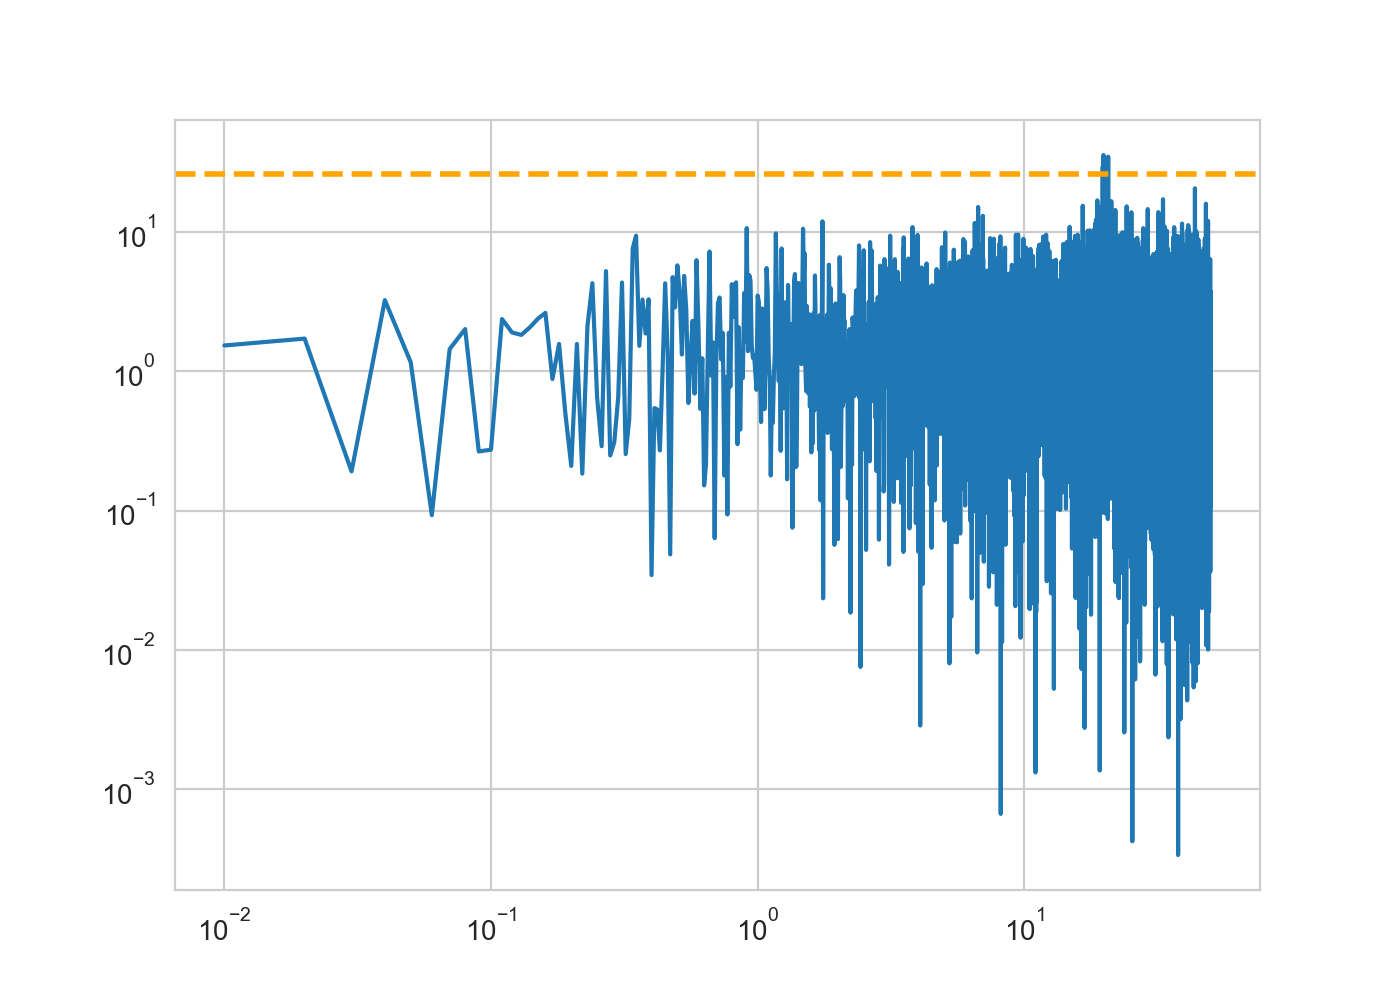

In [41]:
detec_level = pds_detection_level(epsilon=0.01, ntrial=ntrial)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.loglog(ps_sim.freq, ps_sim.power)
ax.axhline(detec_level, lw=2, color="orange", ls="dashed")

You can see a single bin, sort of poking out from above the threshold, but that's not really an accurate reflection of the signal strength, since it's spread over so many different frequencies. 

Can we do the same for the averaged periodogram? Well, yes, of course. The `AveragedPeriodogram` object stores an attribute called `m`, which records the number of powers averaged in each bin. When averaging multiple periodograms, `m` is a single number, because the number of powers averaged in each bin is the same.

We can use this number when calculating thresholds and probabilities using `pds_probability` and `pds_detection_level`:

In [42]:
aps_sim.m

100

Let's plot the averaged periodogram with the detection level:

<IPython.core.display.Javascript object>


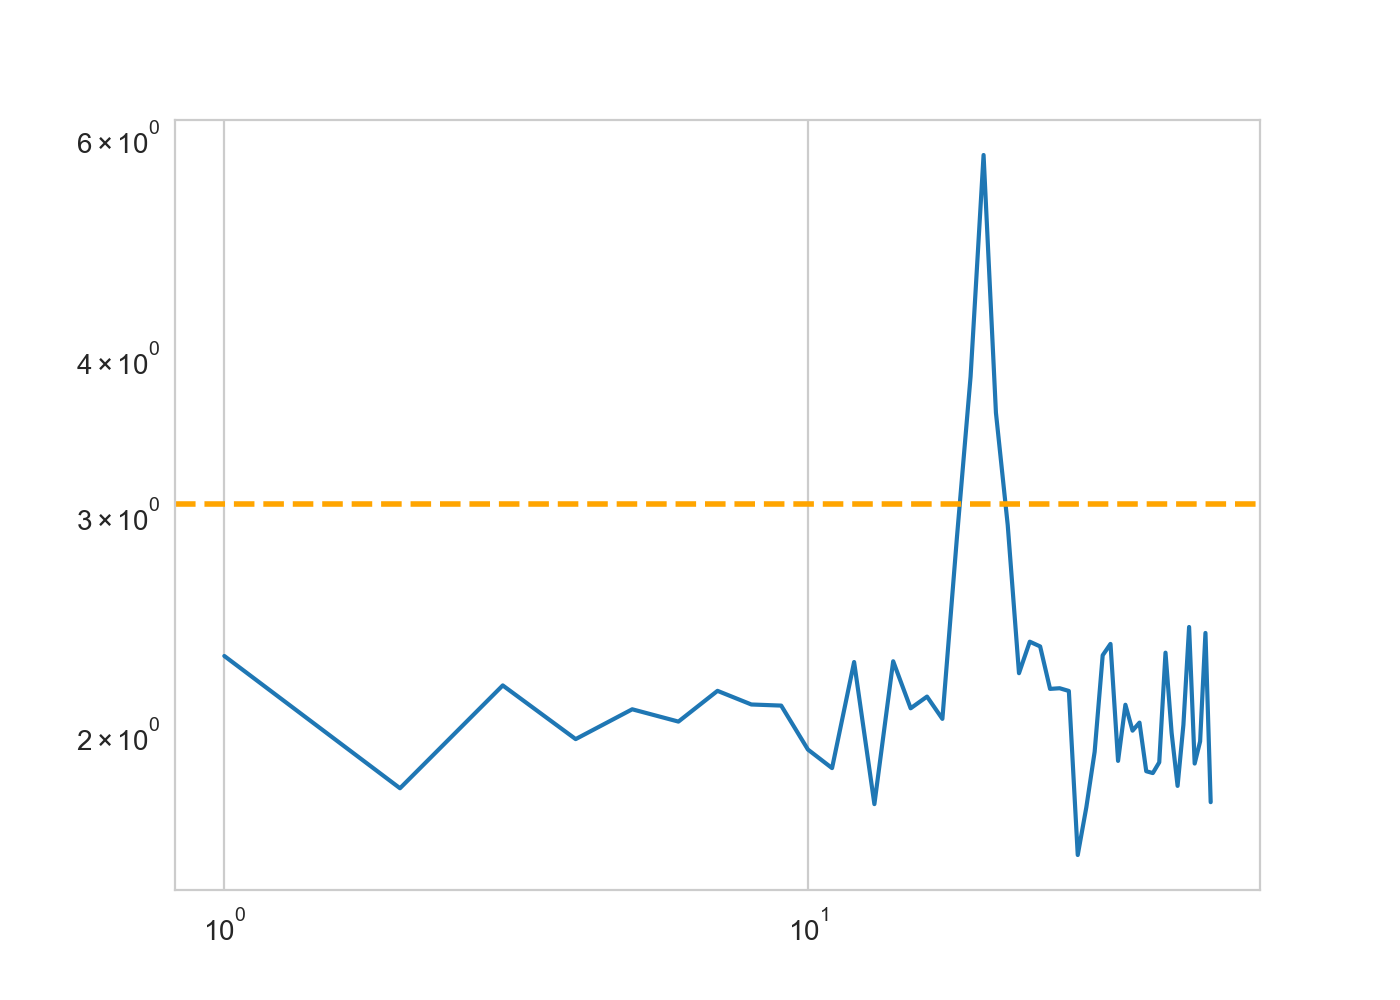

In [43]:
detec_level = pds_detection_level(epsilon=0.01, ntrial=ntrial, n_rebin=aps_sim.m)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.loglog(aps_sim.freq, aps_sim.power)
ax.axhline(detec_level, lw=2, color="orange", ls="dashed")

Another thing you can do, for example when you don't have a way to average periodograms and have to work with a single, non-averaged periodogram, is *logarithmic binning*: the bin width gets larger as a function of frequency. This often works because quasi-periodic signals at higher frequencies also tend to have larger widths. Let's give it a try:

In [44]:
ps_sim_logbin = ps_sim.rebin_log()

This function defines successively larger bins, and then averages all powers falling within a bin. This has the same effect as averaging segments: for each bin, it reduces the width of the expected noise distribution.

<IPython.core.display.Javascript object>


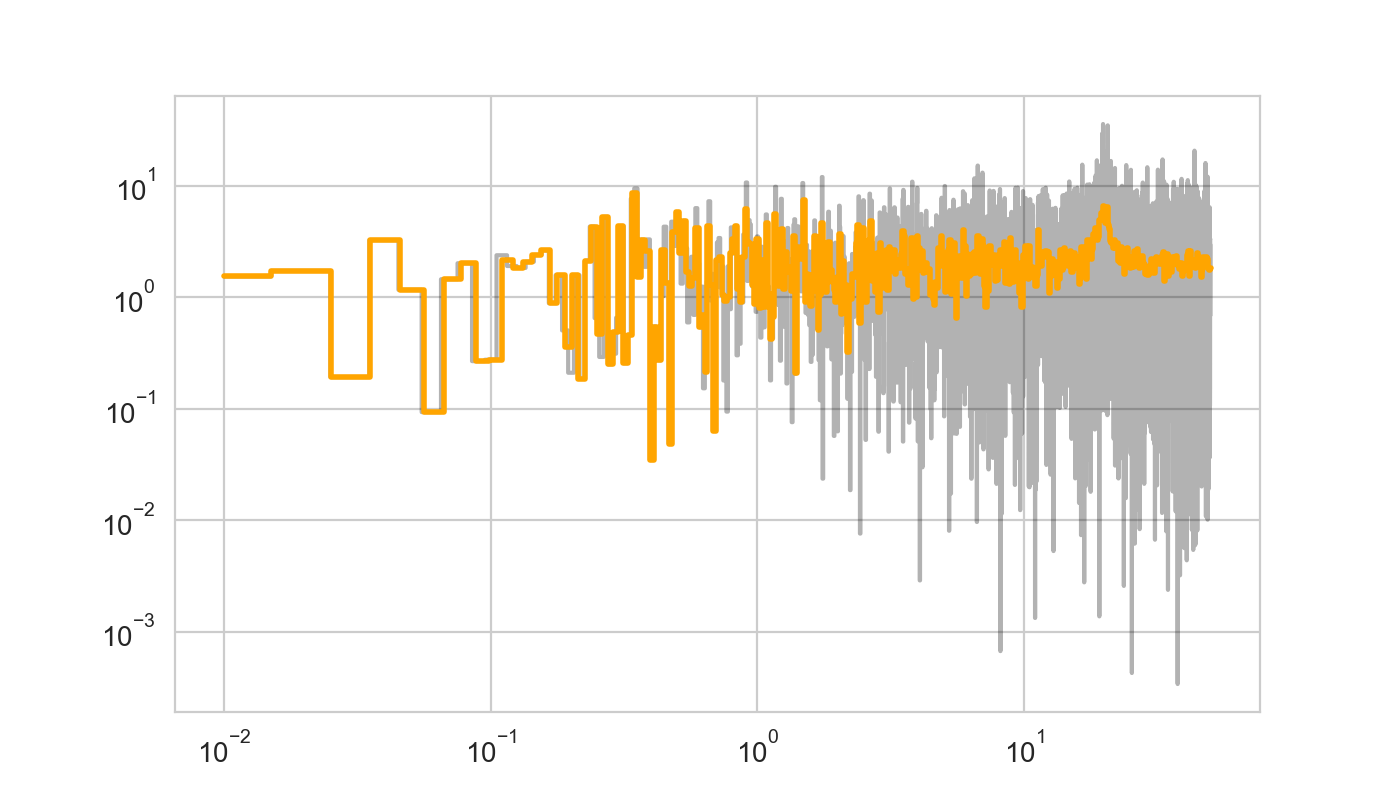

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", c="black", alpha=0.3)
ax.loglog(ps_sim_logbin.freq, ps_sim_logbin.power, ds="steps-mid", c="orange", lw=2)

Note that here, *every frequency bin* may have a different number of powers averaged in it. The attribute `m` will be different for each bin in the new spectrum:

In [46]:
ps_sim_logbin.m

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  2,  1,  1,  2,  1,
        2,  1,  2,  1,  1,  2,  1,  2,  1,  2,  1,  2,  2,  1,  2,  1,  2,
        2,  1,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  2,  3,  2,
        2,  3,  2,  2,  3,  2,  3,  2,  3,  2,  3,  3,  2,  3,  2,  3,  3,
        3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,
        3,  3,  4,  3,  3,  4,  3,  4,  3,  4,  4,  3,  4,  4,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  4,  4,  5,  4,  5,  4,
        5,  5,  4,  5,  5,  5,  4,  5,  5,  5,  5,  5,  6,  5,  5,  5,  6,
        5,  6,  5,  6,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
        6,  7,  6,  7,  7,  6,  7,  7,  7,  7,  7,  7,  8,  7,  7,  8,  7,
        8,  8,  7,  8,  8,  8,  8,  8,  9,  8,  8,  9,  8,  9,  9,  9,  9,
        9,  9,  9,  9, 10

That means that every bin has its own threshold. The method `classical_significances` is clever, though, and knows about this feature. It's therefore a straightforward way to get a first idea of the significance:

In [47]:
pval, idx = ps_sim_logbin.classical_significances(threshold=0.01, trial_correction=True)

In [48]:
ps_sim_logbin.freq[np.array(idx, dtype=int)]

array([19.29214551, 19.49501696, 19.69991713, 19.9068663 , 20.11588496,
       20.32699381, 20.54021375, 20.75556589])

So it looks like there are multiple significant bins, but all of them are around 20 Hz, where the peak in the periodogram is. One thing we can do is increase the binning. `rebin_log` takes a parameter that specifies the fraction by which each subsequent bin will be larger than the previous bin. By default, that parameter is 0.01, so each bin will be 1% larger than the previous bin.

**Exercise**: How large do you have to make `f` in the command below in order to get the QPO into a single bin? How big is that bin (hint: you can estimate it by eye from the plot)? 

In [49]:
ps_sim_logbin = ps_sim.rebin_log(f=0.1)

<IPython.core.display.Javascript object>


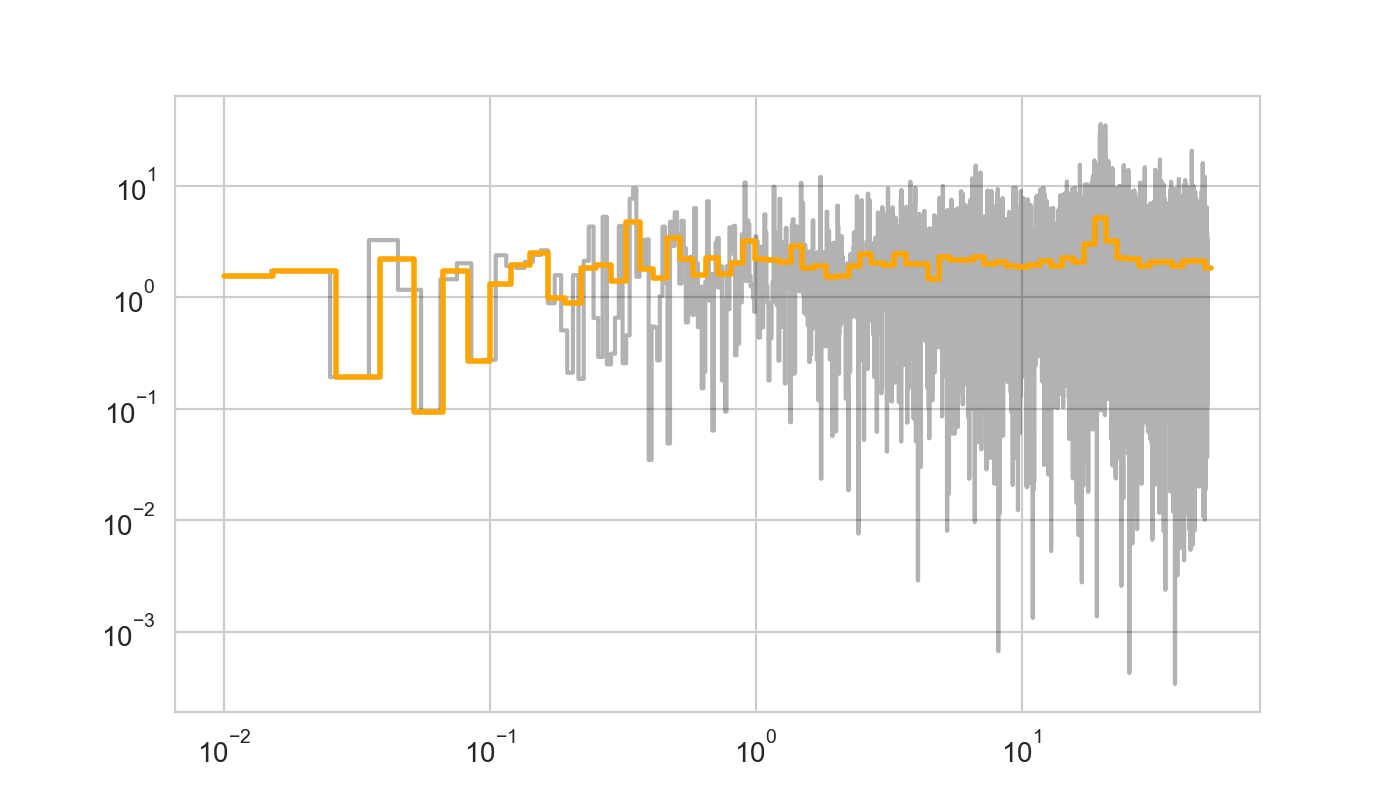

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", c="black", alpha=0.3)
ax.loglog(ps_sim_logbin.freq, ps_sim_logbin.power, ds="steps-mid", c="orange", lw=2)

In [51]:
pval, idx = ps_sim_logbin.classical_significances(threshold=0.01, trial_correction=True)

In [52]:
pval

array([3.21146089e-07, 6.04160550e-51, 1.93812248e-11], dtype=float128)

In [53]:
idx

array([54., 55., 56.], dtype=float128)

In [54]:
ps_sim_logbin.freq[np.array(idx, dtype=int)]

array([17.95155451, 19.75620996, 21.74133096])

If all you want is to find out whether there's likely a signal in your data that can't be explained by pure white noise, the above probably gives you a reasonably good first indication. However, one trade-off with binning is that you loose the ability to really characterize the signal. With a strictly periodic signal, where most of the power is concentrated in a single bin, this is not super important. For a quasi-periodic oscillation, or QPO for short, you're often interested in its centroid frequency, its width, and the total variance contained in the signal. These are difficult to estimate from a heavily binned periodogram. In this case, you'll likely want to *fit a function*, most often a Lorentzian, to the periodogram. We'll not do that here, but you'll encounter fitting again in the next section. For a longer tutorial, take a look at [this one](https://stingray.readthedocs.io/en/latest/modeling.html). 

## Testing Against Red noise

The above still assumes that if there were no periodic or quasi-periodic signal, all we'd see is white noise. In reality, this is often not the case. Especially accreting sources like X-ray binaries and active galactic nuclei are known to exhibit stochastic, aperiodic variations in brightness at low frequencies, what in the literature is often also called "red noise" (as opposed to "blue noise"). Our task then becomes trying to find a QPO against a background of red noise. 

Let's take a look at an example. As before, we'll simulate data, so that we know what we put in (or at least, I know what I put in; you get to find out :)). 

In [55]:
def powerlaw(x, amp, pl_idx):
    log_pl = -pl_idx * np.log(x) + np.log(amp)
    return np.exp(log_pl)

In [56]:
qpo_amp = 5.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 1.0 # centroid frequency of the QPO, in Hz
qpo_qual = 10.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

pl_amp = 1.0
pl_idx = 1.5

rms_obs = 0.3 # fractional RMS amplitude of the QPO

tobs = 100.0 # total duration in seconds
dt = 0.01 # time step of the output light curve
npoints = int(np.round(tobs/dt)) # total number of points in original light curve

mean_countrate_obs = 500
mean_counts_obs = mean_countrate_obs * dt

df = 1.0/tobs # frequency resolution of the PSD/CSD
fmax = 0.5/dt # maximum frequency in the CSD/PSD


# list of frequencies
freq = np.linspace(df, fmax, num=npoints//2)

# generate theoretical spectrum
#mspec_qpo = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)
mspec_pl = powerlaw(freq, pl_amp, pl_idx)

#mspec_obs = mspec_pl + mspec_qpo
mspec_obs = mspec_pl

<IPython.core.display.Javascript object>


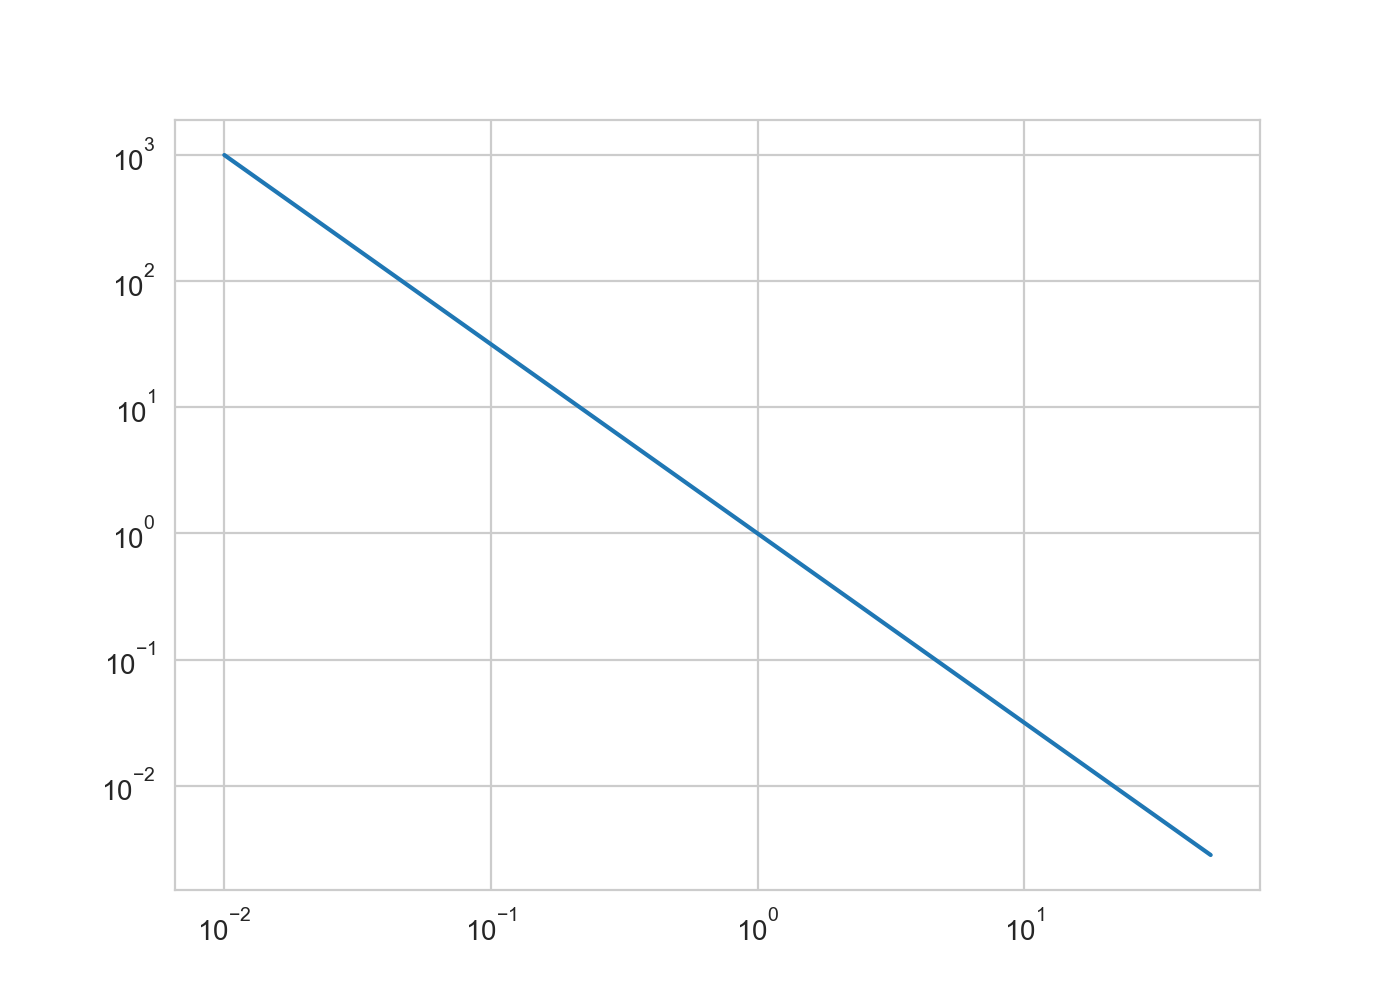

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.loglog(freq, mspec_obs)

Let's simulate a light curve:

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:118: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


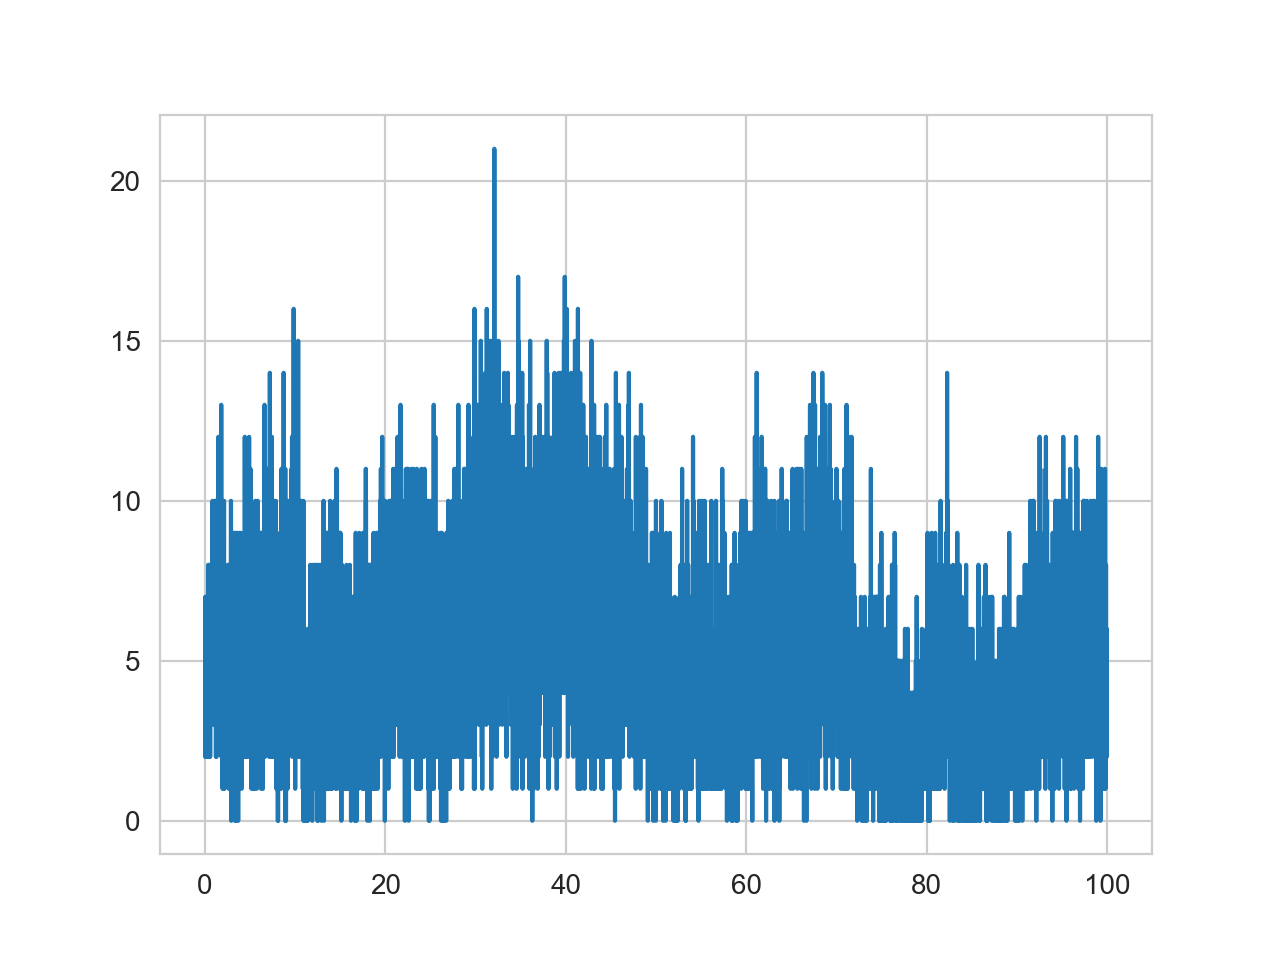

In [58]:
np.random.seed(20210106)
sim = Simulator(dt=dt, N=2*len(mspec_obs), mean=mean_counts_obs, rms=rms_obs)
lc_sim = sim.simulate(mspec_obs)
lc_sim.counts = np.random.poisson(lc_sim.counts)
lc_sim.plot()


Let's save this to file:

In [59]:
np.savetxt("period_detect_example3.txt", np.array([lc_sim.time, lc_sim.counts]).T)

For fun, here's another light curve I've created for you:

In [60]:
data = np.loadtxt("period_detect_example3.txt")
time = data[:,0]
counts =  data[:,1]

lc_sim = Lightcurve(time, counts)

What does this light curve look like?

<IPython.core.display.Javascript object>


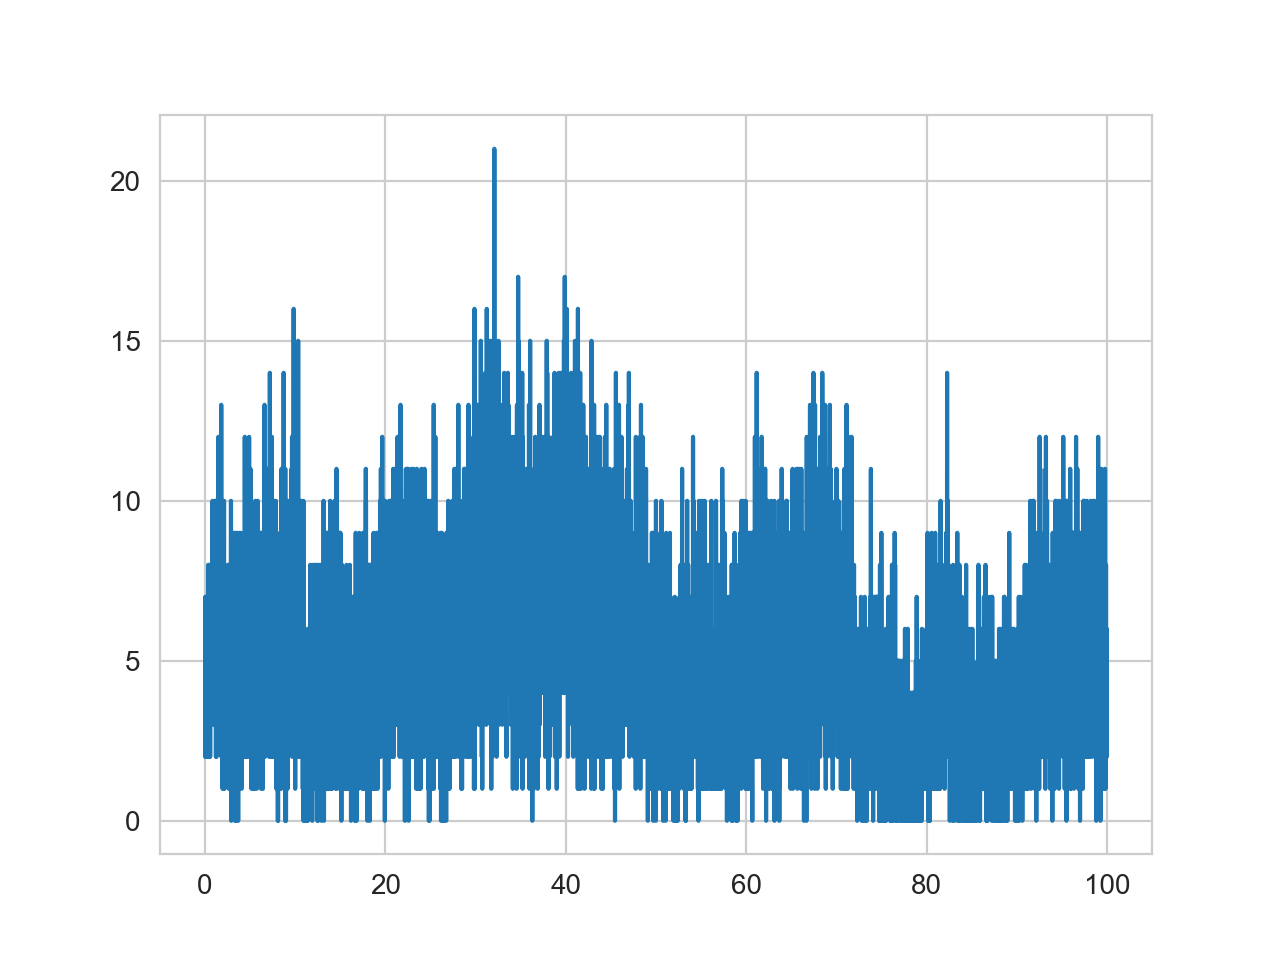

In [61]:
lc_sim.plot()

So that looks marginally more interesting! Do we have a periodic signal or quasi-periodic signal in here? Let's find out!

In [62]:
ps_sim = Powerspectrum(lc_sim, norm="leahy")

In [63]:
aps_sim = AveragedPowerspectrum(lc_sim, segment_size=5.0, norm="leahy")

20it [00:00, 68.53it/s] 


<IPython.core.display.Javascript object>


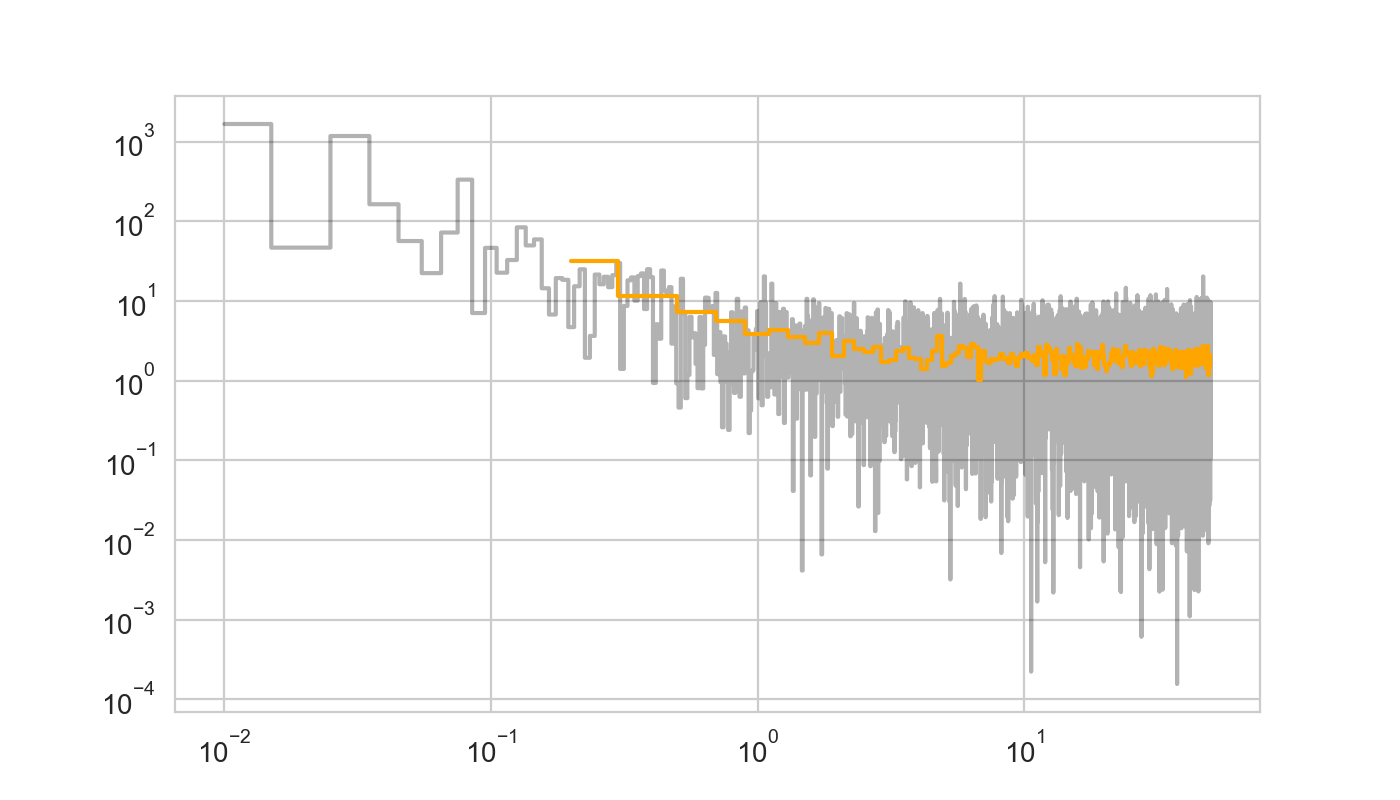

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", c="black", alpha=0.3)
ax.loglog(aps_sim.freq, aps_sim.power, ds="steps-mid", c="orange")


Well, does that look like there's a periodic signal in there? If so, where? And how do we find out? What if we do a standard significance test? Let's plot a threshold for the unbinned periodogram:

In [65]:
thres = pds_detection_level(epsilon=0.01, ntrial=len(ps_sim.power))

<IPython.core.display.Javascript object>


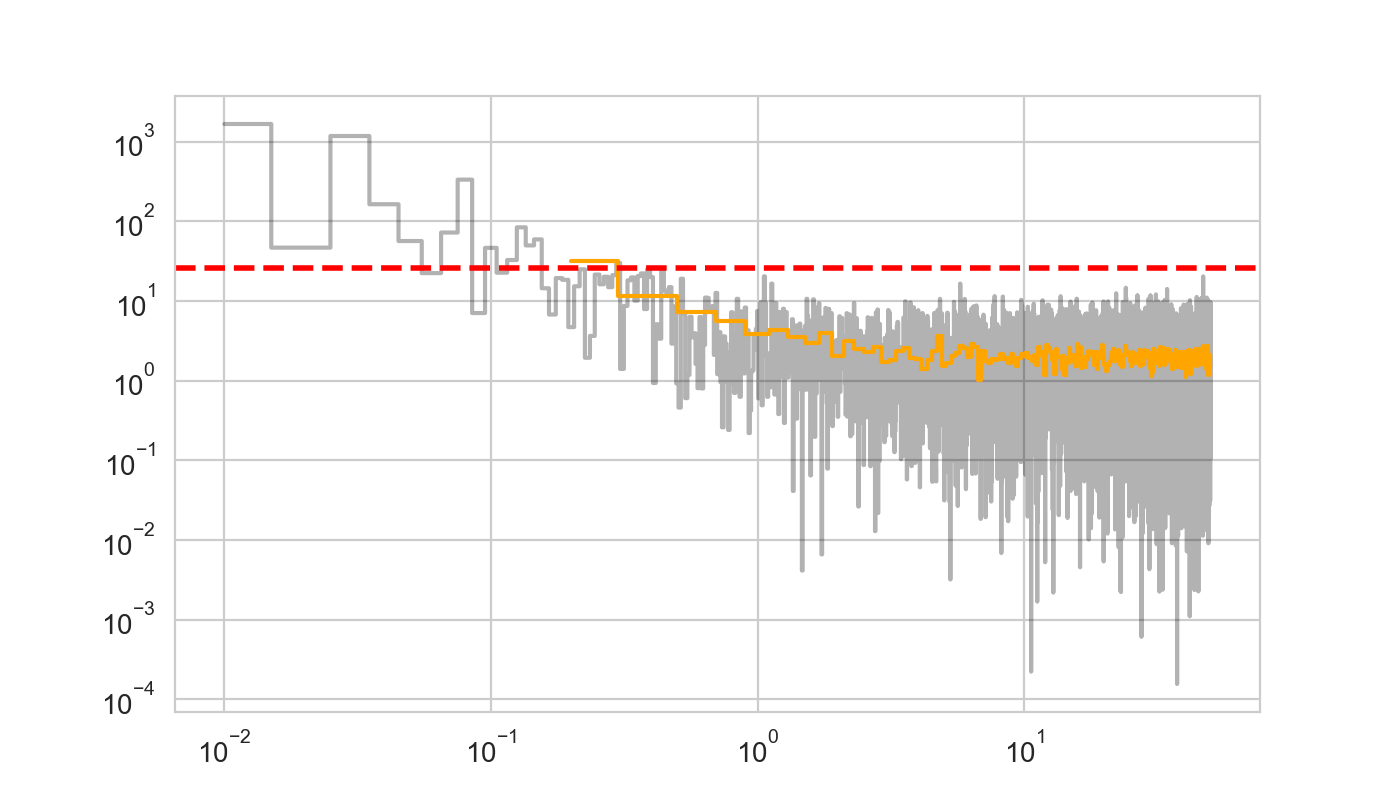

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", c="black", alpha=0.3)
ax.loglog(aps_sim.freq, aps_sim.power, ds="steps-mid", c="orange")

ax.axhline(thres, lw=2, color="red", ls="dashed")

So according to that, *everything* at lower frequencies is above the threshold! They're all QPOs! Clearly, that's not right (or at least, it isn't in most cases). 

### Detrending

So maybe, you say, we could detrend the light curve? 

In [67]:
nn = 500
c = np.convolve(lc_sim.counts, np.ones(nn,)/nn, mode='valid')
ti = np.linspace(lc_sim.time[0]+np.floor(nn/2)*lc_sim.dt, lc_sim.time[-1]-np.floor(nn/2)*lc_sim.dt, len(c))

<IPython.core.display.Javascript object>


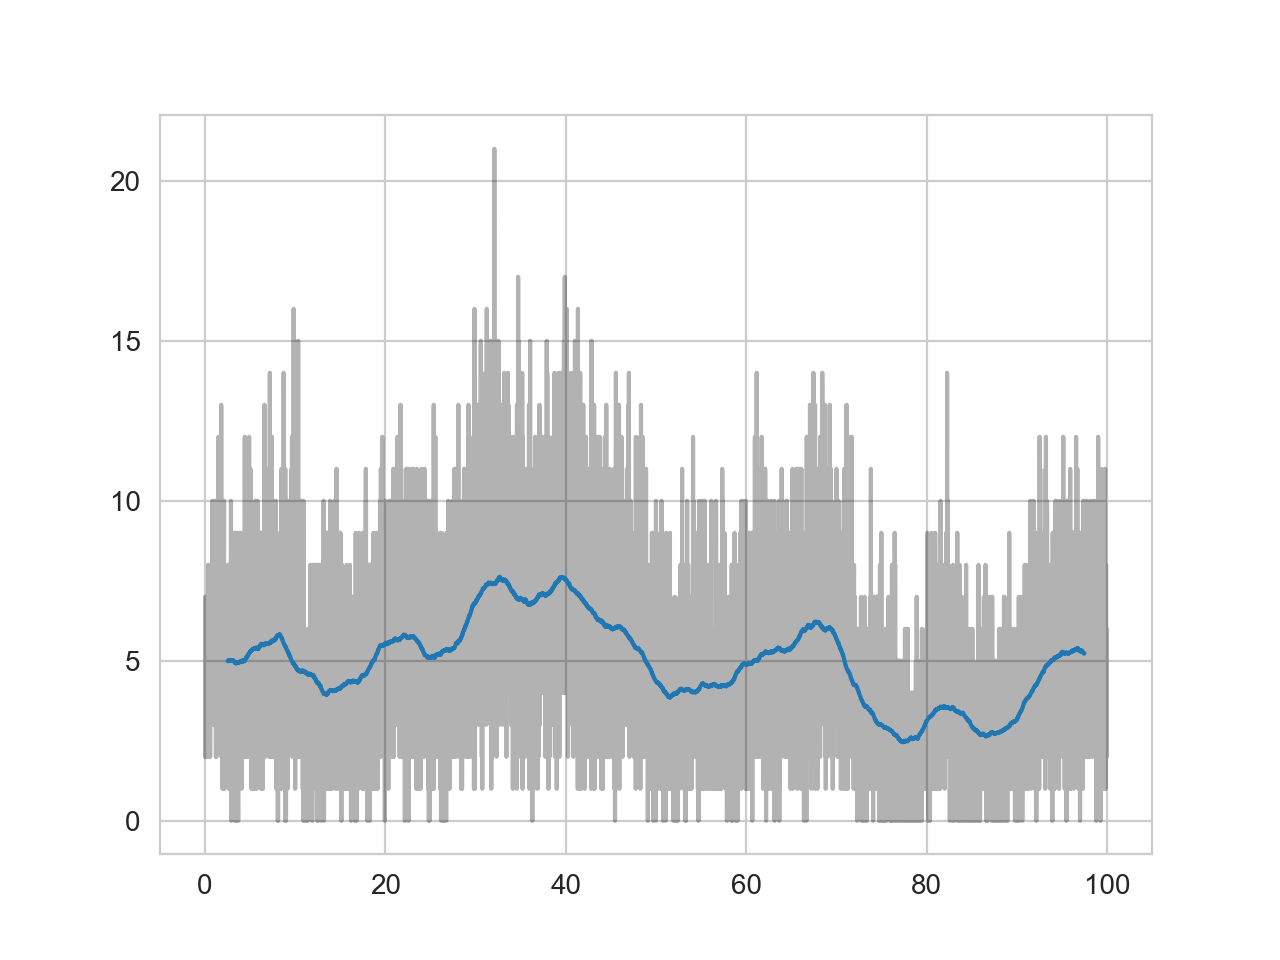

In [68]:
plt.figure()
plt.plot(lc_sim.time, lc_sim.counts, c="black", alpha=0.3)
plt.plot(ti, c)

In [69]:
counts_detrend = lc_sim.counts[int(nn/2):-int(nn/2)+1]/c

In [70]:
lc_detrend = Lightcurve(ti, counts=counts_detrend)

In [71]:
ps_detrend = Powerspectrum(lc_detrend, norm="leahy")

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


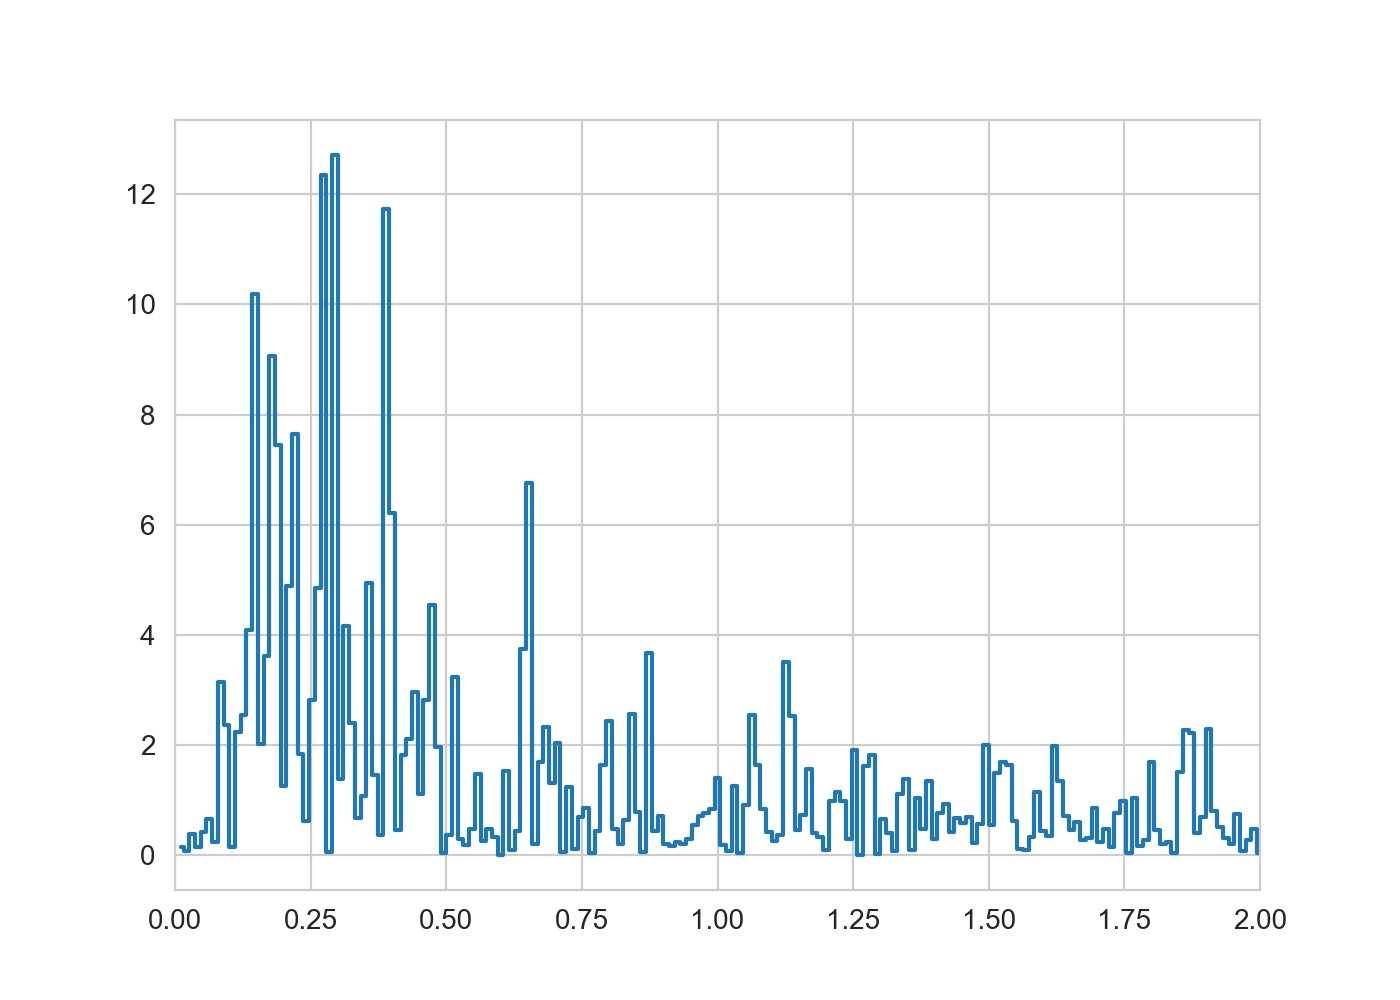

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  


(0, 2)

In [72]:
plt.figure(figsize=(7,5))
plt.plot(ps_detrend.freq, ps_detrend.power, linestyle="steps-mid")
plt.xlim(0,2)



Okay, so we've removed the trend, and what remains looks like a QPO, doesn't it? Except it isn't! What I've given you here is a light curve that's exclusively made of stochastic variability in the form of power-law red noise, there's no QPO in it! What detrending does with these light curves is take out the *lowest frequencies*, but because the power spectrum of the underlying process is a power law, this leaves in decreasing power at a range of frequencies that aren't affected by the detrending. The result can look like a QPO, even when it's not. 

**Important**: When dealing with red noise in your light curves, be careful with detrending. Detrending works best if most of the power is concentrated in a few bins at the very lowest frequencies. Otherwise, taking out some of the variability, but not all, can lead to PSDs that kind of look like a QPO!

### Fitting Red Noise Spectra

There are two ways to do this in a more principled way. The first, more appropriate for narrow or strictly periodic signals, fits a red noise model to the periodogram, then divides out the best-fit model and uses that highest outlier in the residuals as a test statistic. One then simulates pure red noise spectral from a range of plausible model parameters (determined via Markov Chain Monte Carlo Sampling), fits each with the model, and records the highest outlier for the residuals of each simulated spectrum. This provides a sample of highest outliers one would expect in the spectrum if there was no other signal present. The algorithm approximately follows these steps:

1) Define a Bayesian model for the observed periodogram using a broadband noise model (e.g. a power law of a broken power law) and appropriate priors

2) Fit the model to the data using Maximum-A-Posteriori fitting

3) Compute the test statistic, $T_{R, \mathrm{obs}} = \max_j{(2 \frac{P_j}{S_j})}$, where $P_j$ are the observed powers, and $S_j$ are the best-fit model values. 

4) Sample the Bayesian broadband noise model using Markov Chain Monte Carlo sampling

5) Draw $N$ posterior samples, for each, repeat steps 2 and 3 above to generate a sample of simulated $T_{R, \mathrm{sim}}$. 

6) Compare the observed test statistic $T_{R, \mathrm{obs}}$ to the empirical distribution of simulated $T_R$, calculate a tail probability of measuring a value of $T_R$ at least as high as the observed $T_{R, \mathrm{obs}}$ under the null hypothesis that all variability is generated by broadband noise only.

The MCMC sampling in step 4 allows us to take into account the inherent uncertainty in the model parameters for the broadband noise model, and propagate that uncertainty through the inference process. 

The method for a broader QPO is similar, but instead of an outlier test statistic as defined above, it uses a likelihood ratio test for a model that contains a Lorentzian (or similar function representing a QPO) against a broadband noise model. One then simulates from the posterior for the broadband noise model in the same way, and calculates likelihood ratio tests for the simulated spectra. 

We won't go through this process here for time reasons, but if you're interested, I'd highly recommend to read the paper that implemented all this, [Vaughan, 2010](https://ui.adsabs.harvard.edu/abs/2010MNRAS.402..307V/abstract). For a practical implementation in Stingray, you, can also look at the [tutorial](https://stingray.readthedocs.io/en/latest/notebooks/Modeling/ModelingExamples.html#Bayesian-ish-QPO-Searches) in the `stingray` documentation.

**Important**: As we've already encountered above, p-values *only* give you the probability of rejecting the specific null hypothesis you've chosen, here the broadband noise model. That means that a small p-value for $T_R$ or the likelihood ratio test is *not* direct evidence for the presence of a QPO. Be vigilant that other factors, for example a mismatch between the broadband noise model and your data, but also issues with data quality, can yield small p-values without the presence of a QPO!


## Exercise: Exploring Real Data

In the repository is some real data from the well-known black hole X-ray binary GRS 1915+105, observed with NuSTAR (graciously pre-processed for me by Matteo Bachetti). NuSTAR has two identical detectors called FPMA and FPMB, so there are two files. NuSTAR also records individual *photon arrival times*, i.e. the arrival time of each photon at the detector (it also records an energy for the photon, but we'll not worry about those right now). Note that this is a small snapshot of a much longer observation; the full data set is several GB large!  

The photon arrival times in the two detectors are saved in the files `grs1915_nustar_fpma.txt` and `grs1915_nustar_fpmb.txt`. 

First, load the data using `np.loadtxt`

In [73]:
data_a = np.loadtxt("grs1915_nustar_fpma.txt")
data_b = np.loadtxt("grs1915_nustar_fpmb.txt")

Next, we'll need to turn these into light curves. You can do this using the `Lightcurve.make_lightcurve()` method. Check the [`stingray` documentation]() for its possible parameter. One parameter you'll need to pick is the time resolution `dt`. NuSTAR's temporal resolution is $2\mu s$, but you'll probably not want to choose a resolution that high. However, in some types of X-ray sources, periodicities at hundreds of Hz exist, so play around with the resolution. Choose a coarse one and a fine one, then plot the result. What do you see?

**Note**: By default, without any more information, the `make_lightcurve` method will start the first bin at the first photon. This is slightly incorrect in practice, because that's not necessarily the true start of the observation. If you *know* the start of the observation and its duration, it's helpful to add those to the `make_lightcurve` method. This will ensure that the light curves coming out will have the exact same time stamps.

For this observation, here are the start times and duration:

In [74]:
tstart = 261813655.98579582572
tseg = 1893.1608213186264038

Now turn those event lists into light curves, and plot the results:

In [75]:
dt = 0.5/1000.0 # I want the PSD to go up to 1000 Hz

lca = Lightcurve.make_lightcurve(data_a, dt, tstart=tstart, tseg=tseg)
lcb = Lightcurve.make_lightcurve(data_b, dt, tstart=tstart, tseg=tseg)

In [76]:
dt_coarse = 0.5/10.0 # I want the PSD to go up to 1000 Hz

lca_coarse = Lightcurve.make_lightcurve(data_a, dt_coarse, tstart=tstart, tseg=tseg)
lcb_coarse = Lightcurve.make_lightcurve(data_b, dt_coarse, tstart=tstart, tseg=tseg)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


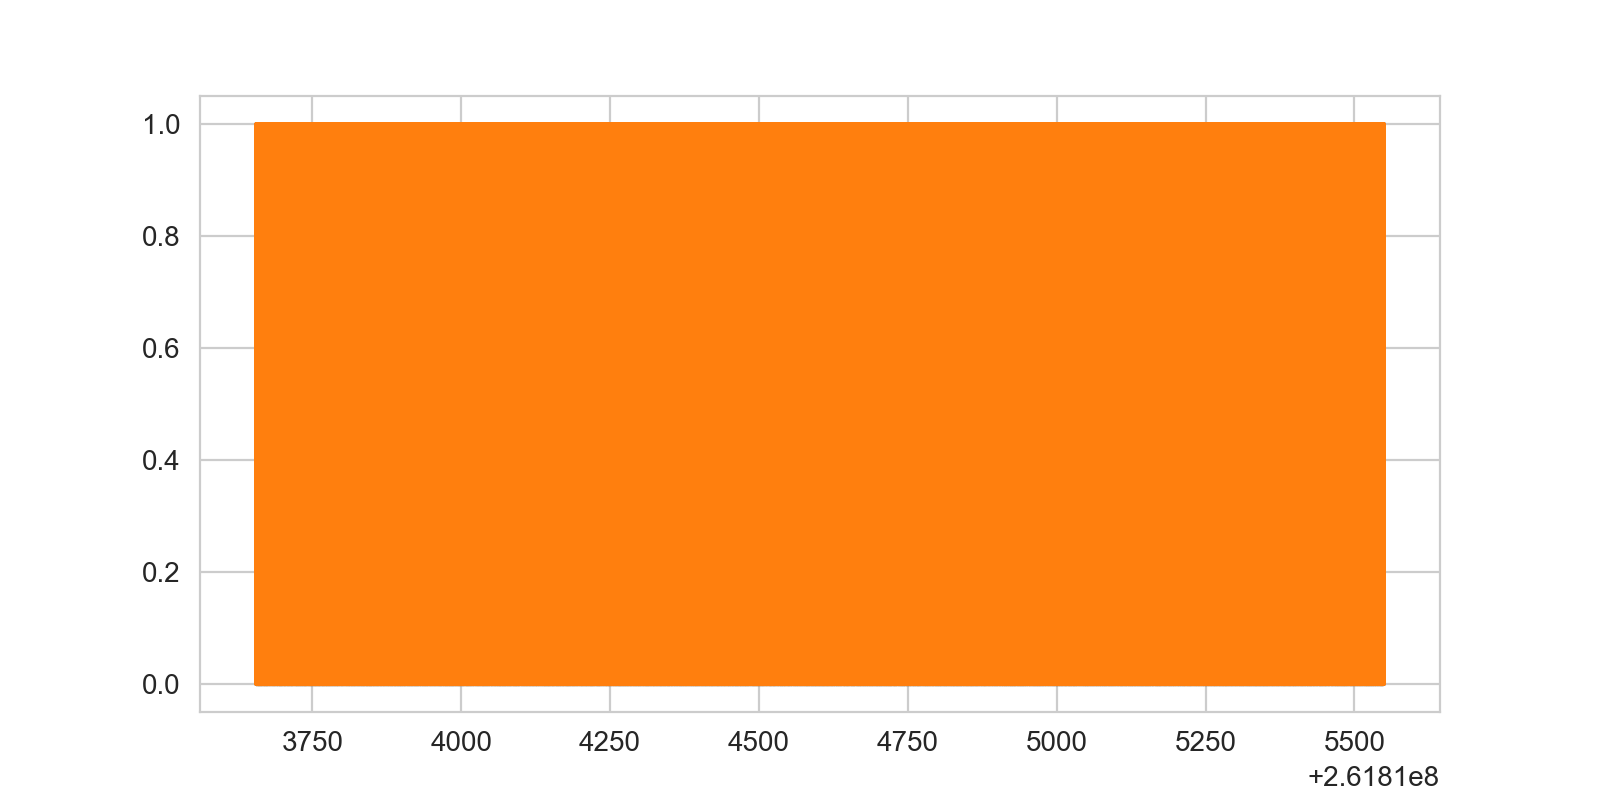

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lca.time, lca.counts)
ax.plot(lcb.time, lcb.counts)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


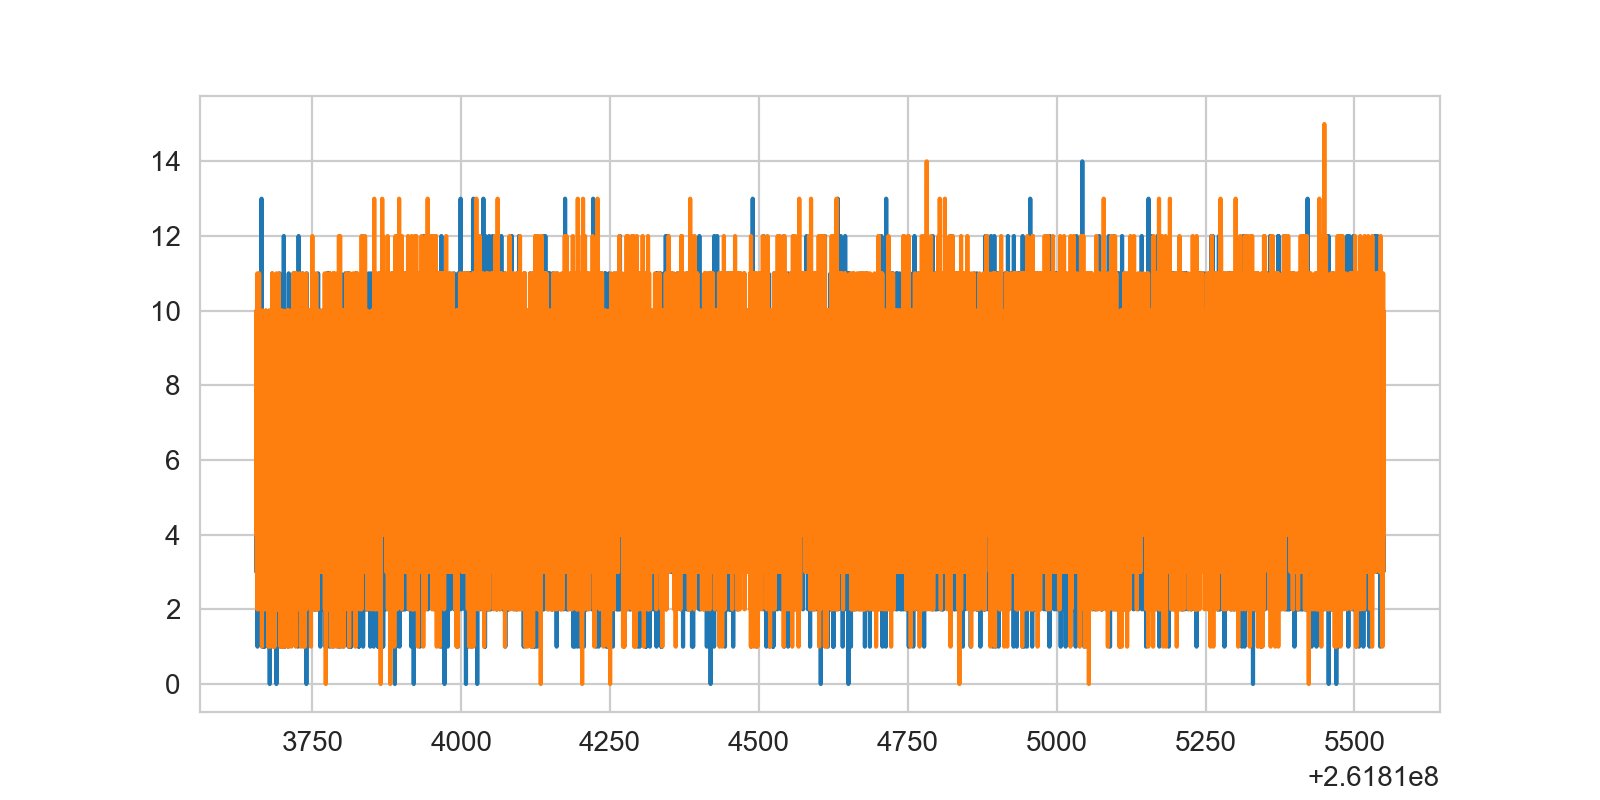

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lca_coarse.time, lca_coarse.counts)
ax.plot(lcb_coarse.time, lcb_coarse.counts)

For the Fourier analysis, we want to continue with a light curve that combines all the photons from both detectors. This can be done by adding the two light curves together. You can actually do that by using the "+" operator.

In [79]:
lc = lca + lcb

Okay, now make a periodogram, and plot the result. What kind of features do you see? Which ones look possibly periodic? Which ones look quasi-periodic? Which ones look aperiodic? Write down what you see. 

In [80]:
ps = Powerspectrum(lc, norm="leahy")

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


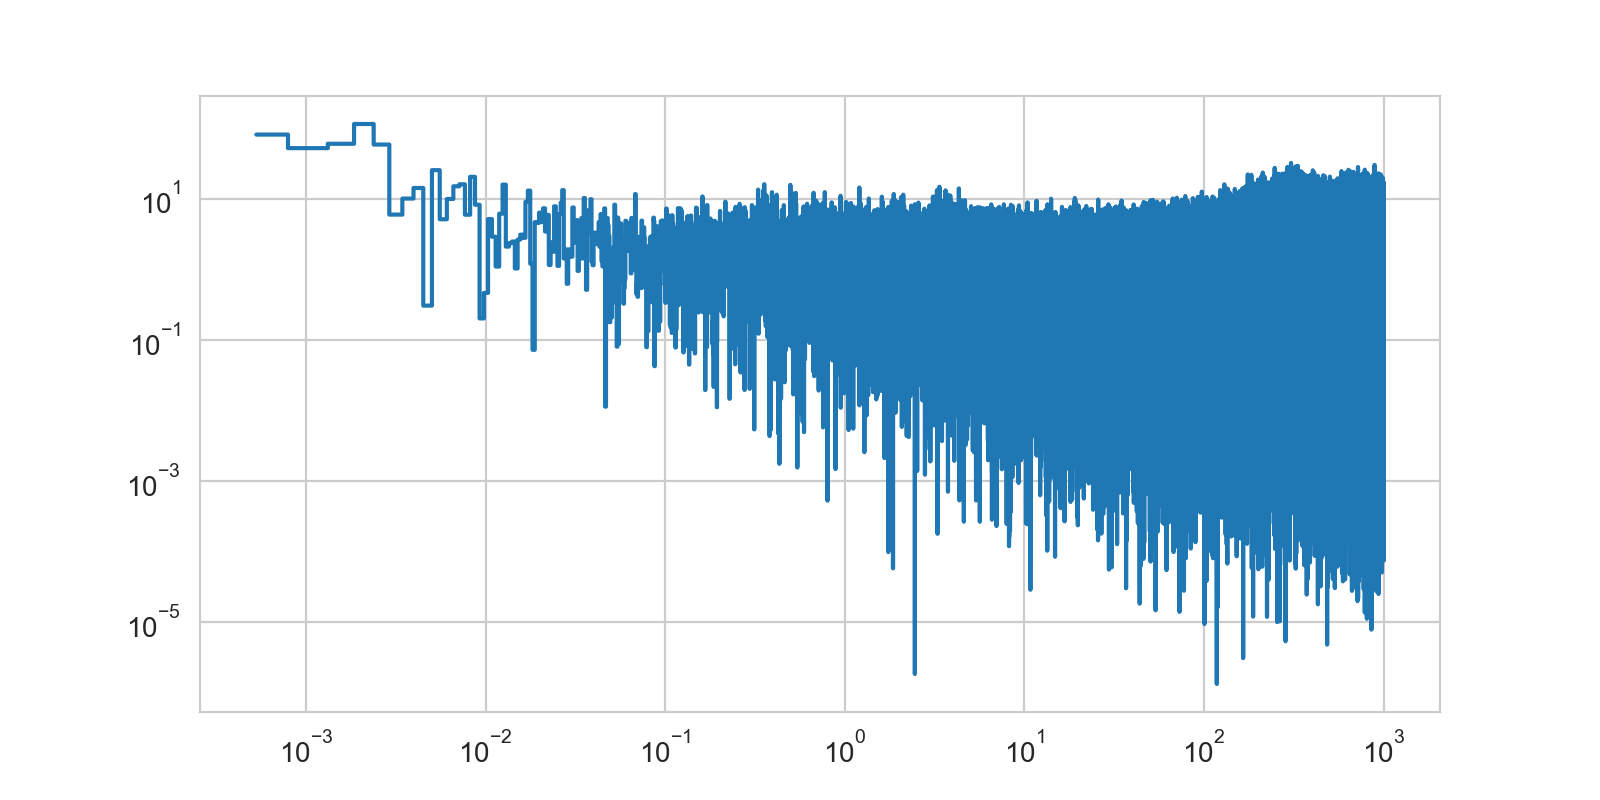

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(ps.freq, ps.power, ds="steps-mid")

For the signals you see, can you determine significance using the classical $\chi^2$ statistical significance implemented in `pds_probability`? Why or why not? 

Plot a threshold to see if anything looks significant compared to white noise.

In [82]:
threshold = pds_detection_level(epsilon=0.01, ntrial=len(ps.freq))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


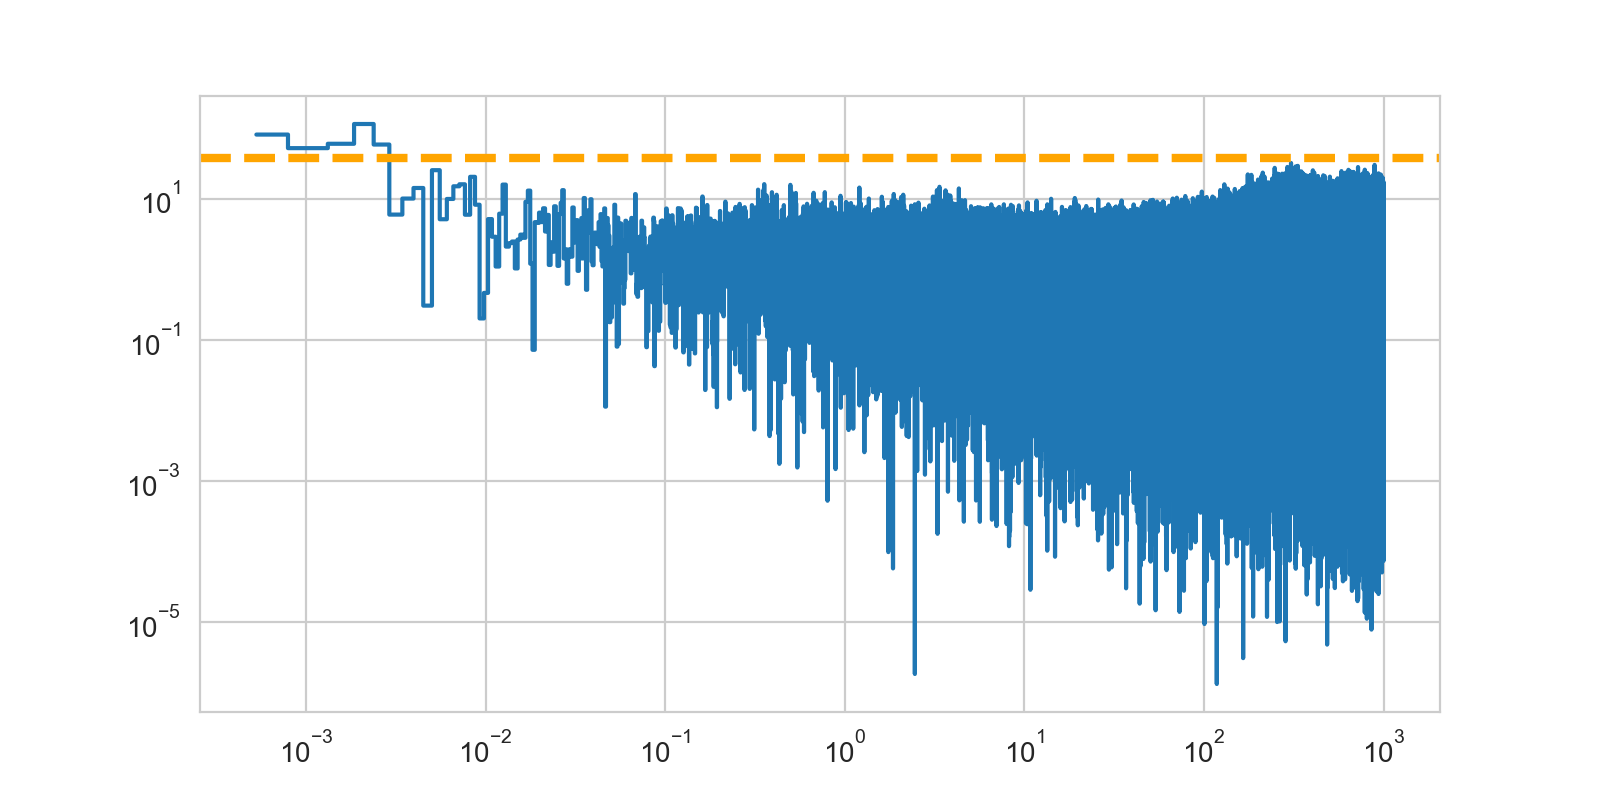

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(ps.freq, ps.power, ds="steps-mid")
ax.axhline(threshold, lw=3, color="orange", ls="dashed")

Are there potentially interesting features that might be more visible in an averaged periodogram? How can you set the `segment_size` parameter for the averaged periodogram in order to optimize the signal-to-noise ratio in the periodogram to see some of those signals more clearly? Make multiple averaged periodograms that focus on different features in the periodogram.

In [84]:
segment_size = 4.0
aps = AveragedPowerspectrum(lc, segment_size, norm="leahy")

473it [00:03, 152.71it/s]


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


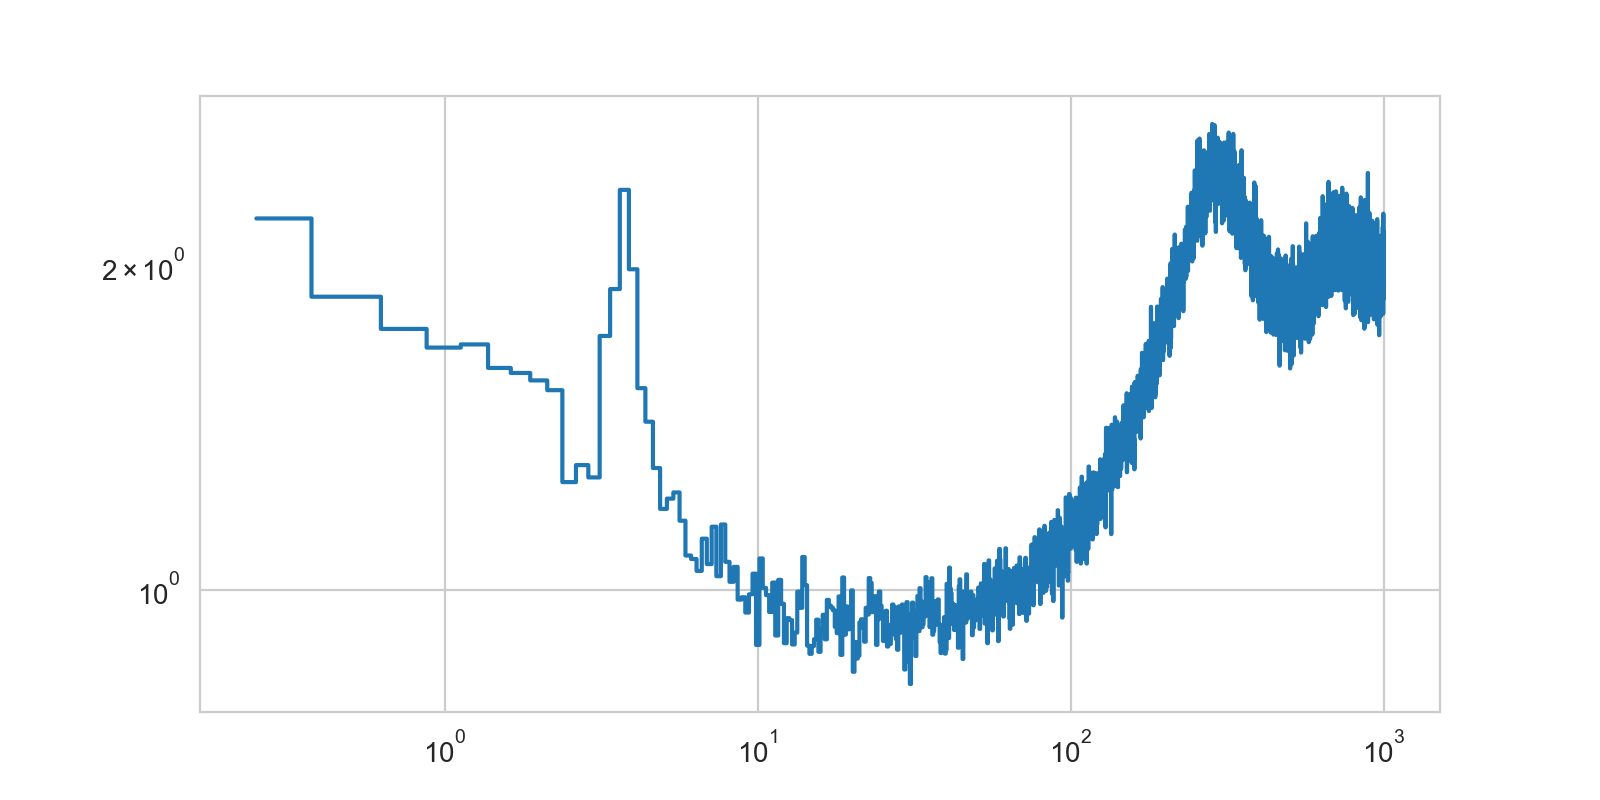

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(aps.freq, aps.power, ds="steps-mid")


How would you go from here? Given what you learned today, how would you assess whether any of the features you see are real?

### Solutions

There are four interesting features in the data: 
* a red noise part at low frequencies, 
* a QPO at around 4 Hz, 
* a periodic signal at around 891Hz and 
* strange wavy structure at high frequencies. 

The red noise and the QPO are actual variability in the source, so they can tell you interesting information about the black hole X-ray binary under study. However, the other two are not real: the sharp spiky signal at 891Hz is a quirk of NuSTAR: every so ofte, NuSTAR records housekeeping data. That process imprints onto the light curve in the form of a sharp, periodic signal at high frequencies.

**Important**: If you see a signal in more than one observation from different scientific sources, if a signal changes frequency or goes away when you e.g. change the time resolution, it's likely not real. If you see something spectacular and you're not sure it's real, check back with the instrument team! They can usually tell you whether there's something funny at those frequencies.

The wavy structure at high frequencies is *also* not real. This is due to dead time: when a photon arrives at the NuSTAR detector, within about 2.5ms, the detector is blocked while it records that photon, and cannot record any other photon. Any photon arriving within that time will be lost. So if you have a bright source, which emits many photons, you (1) lose a lot of photons, (2) imprint structure onto the periodogram as can be seen in the periodograms you made. 

One way to approach the latter problem is to make a `cospectrum`: For this, you can use the `Crossspectrum` and `AveragedCrossspectrum` classes in Stingray together with the individual light curves from FPMA and FPMB to generate the cospectrum (the real part of the cross spectrum). Try this out below, and plot the resulting spectra. How do they differ from the periodograms?

In [86]:
from stingray import AveragedCrossspectrum

In [87]:
acs = AveragedCrossspectrum(lca, lcb, segment_size, norm="leahy")

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
473it [00:17, 27.12it/s]
473it [00:06, 76.49it/s]
473it [00:06, 75.09it/s]


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


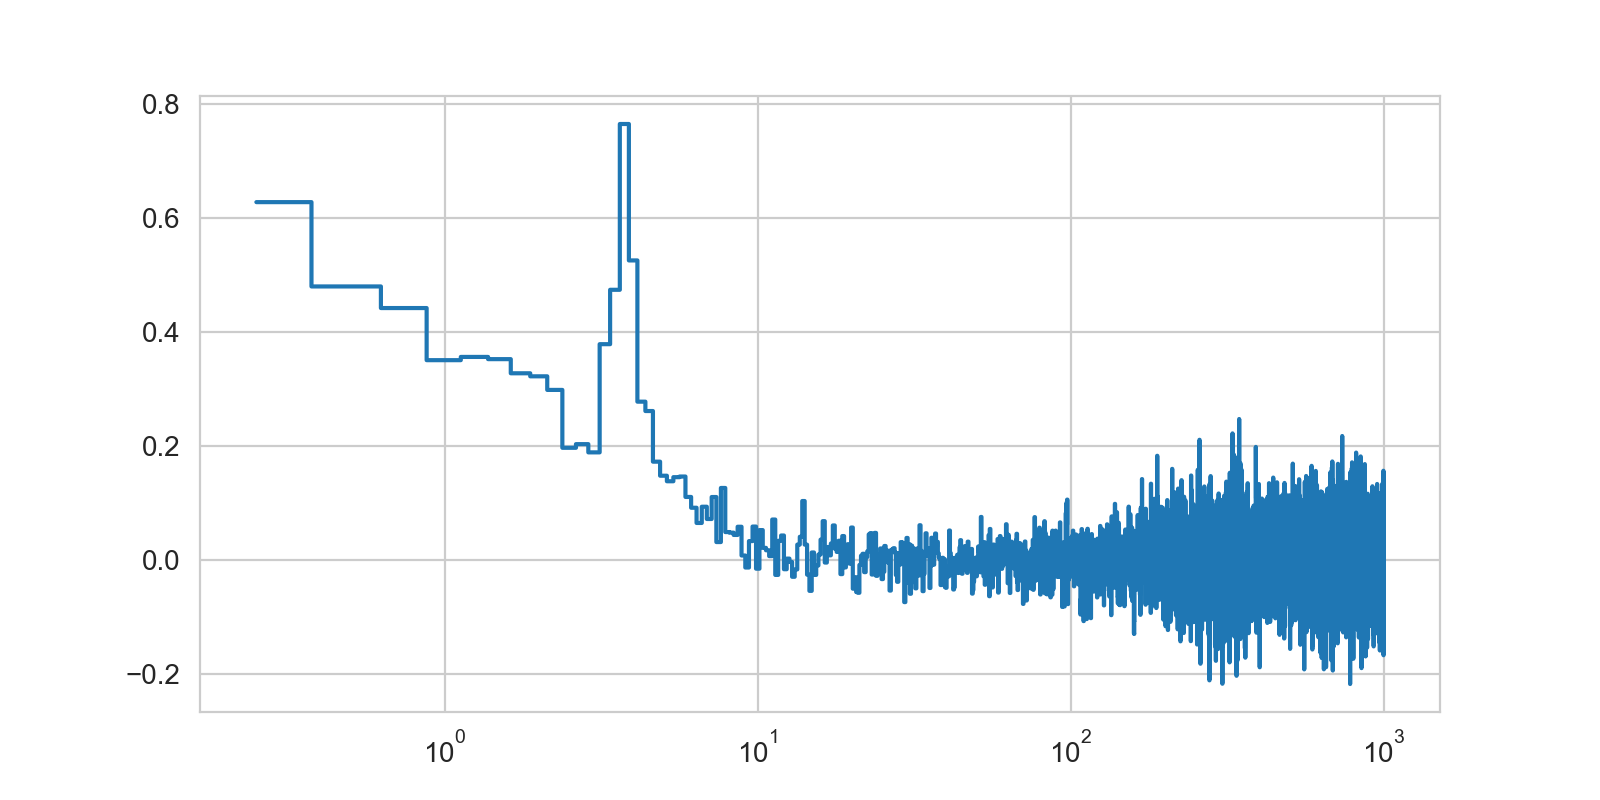

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.semilogx(acs.freq, acs.power, ds="steps-mid")


This has less of the dead time structure, but note that the variance in the powers is still quite weird.  

## Concluding Remarks

1) Check your assumptions. All statistical methods make assumptions about the structure of the problem and the properties of the data. They might assume that the data is free of instrumental effects like dead time. There might be variability in the data that you've not recognized, but invalidates the white noise null hypothesis. Be vigilant about effects *other* than a (Q)PO that could yield a detection there is no regularly repeating signal in the data. 

2) However, you also want to use the simplest model and approach you can get away with. The more complicated the model, the more things can go wrong in the data analysis. And sometimes, you don't need the complex model. For example, even if you have broadband noise at low frequencies, you probably won't have to take it into account if the signal you're looking for is at high enough frequency to be effectively in a white noise regime (say, your broadband noise is at Hz frequency, but you're looking at kHz QPOs). 

3) I have only ever encountered two cases: (1) where a (Q)PO was so strong that you can unambiguously identify it in the periodogram by eye, and (2) where you're really not sure, and it's very ambiguous, and you need to do a lot of work to get an idea of whether there is a signal in the data. In the former case, the test for significance becomes more or less a formality, and the interesting work is in characterizing a signal. In the second case, I've found that rarely a single method presented the "right" or even "best" answer. Instead, I often try multiple competing and often mutually exclusive null hypotheses and multiple methods, and use the results to get a fuller picture of the data and whether there's an interesting periodic signal in it. 